In [1]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from tensorflow.keras.utils import plot_model

In [3]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk
from comsolml.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results

In [4]:
sensorindex = [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10, 11]
timesamples = 400
noisedb = -12
encoding_dim = 64
dt = 1e-6
dx = 3456*0.2e-3/12
data_augmentation = False

In [5]:
mat = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces.mat'))

In [6]:
X = mat['concat_traces'].astype('float32')

In [7]:
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (1250, 73, 401))

In [8]:
X = X[:,::6,:]

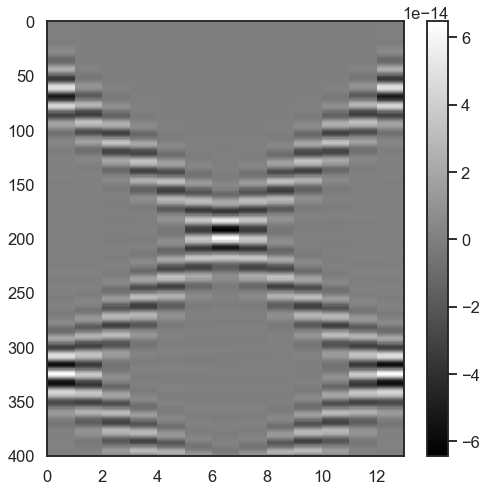

In [9]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [10]:
X.shape[-1]

401

In [11]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

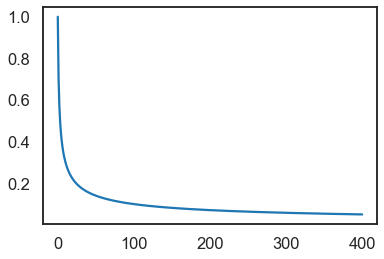

In [12]:
plt.plot(1/(time_scaling[0]))
plt.show()

In [13]:
#X = np.multiply(X, time_scaling)

In [14]:
X = np.divide(X, time_scaling)

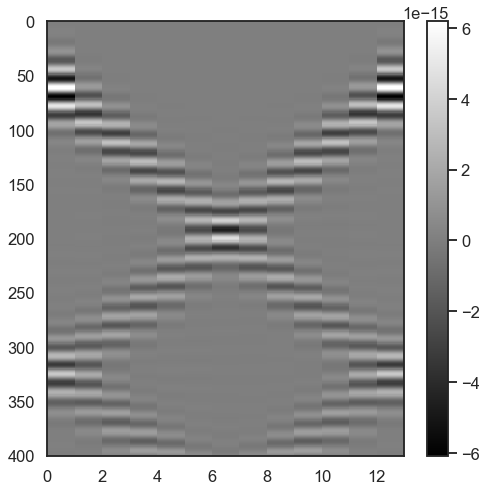

In [15]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [16]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels.csv'))

In [17]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [18]:
cases_ideal = labels[(labels['Depression depth'] == 0) & (labels['Pitting depth'] == 0)].index.tolist()

In [19]:
cases_ideal

[121, 230, 231, 679, 896, 1006, 1133]

In [20]:
from acoustics import generator
def make_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.normal(loc=0, scale=1, size=noiseshape)*noiselev
  else:
    noise = np.zeros(noiseshape, dtype='float32')
    for i in range(noiseshape[0]):
      for j in range(noiseshape[1]):
        noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [21]:
X_sample_c = X[:,:,:timesamples]/X.max()
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)
#X_sample_n = make_noise(noisedb, X_sample_c.shape)
label_sample = labels

X_sample_n = np.expand_dims(X_sample_n, 1)
X_sample_c = np.expand_dims(X_sample_c, 1)

In [22]:
#label_sample = label_sample.sample(frac=1) # Remove in production!!

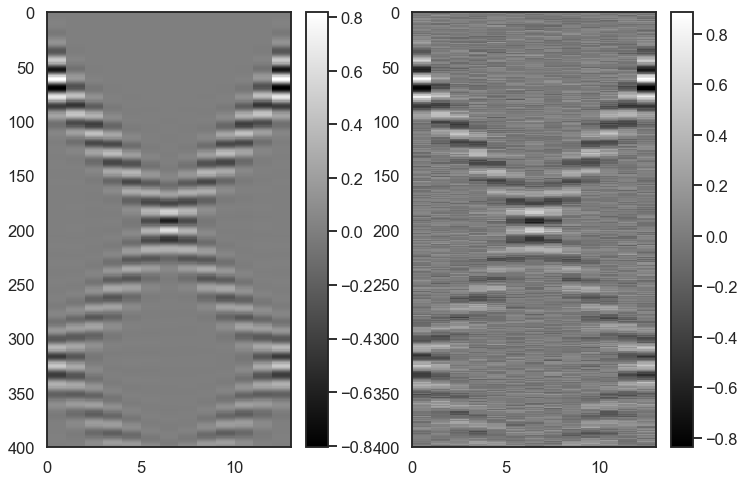

In [23]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [24]:
def pick_sensors(X_sample, sensorindex):
  # Sparse sensor mode:
  X_sample = np.take(X_sample, sensorindex, axis=2)
  if len(sensorindex)==1:
    X_sample = np.expand_dims(X_sample, 2)
  return X_sample

In [25]:
X_sample_n = pick_sensors(X_sample_n, sensorindex)
X_sample_c = pick_sensors(X_sample_c, sensorindex)
X_sample_n.shape, X_sample_c.shape

((1250, 1, 11, 400), (1250, 1, 11, 400))

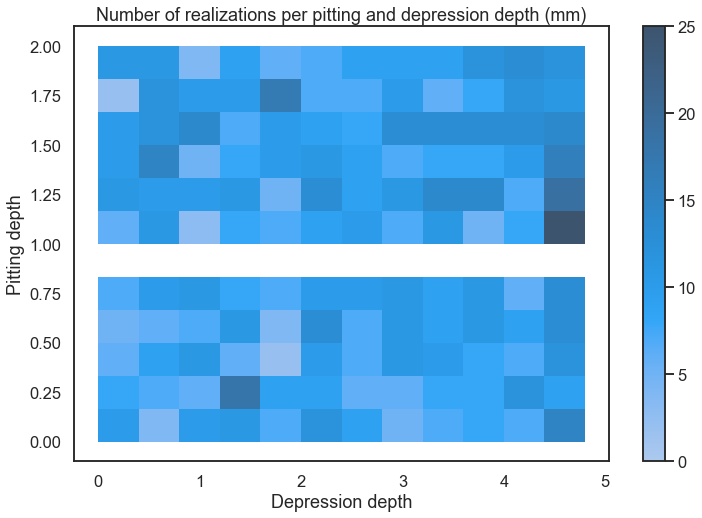

In [26]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression depth", y="Pitting depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

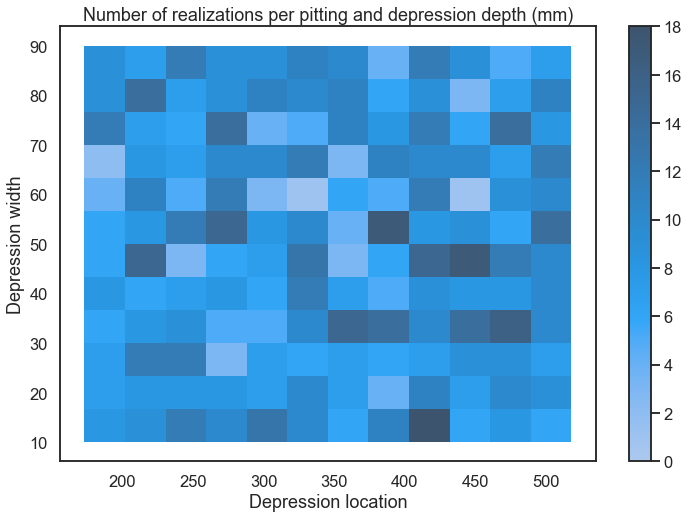

In [27]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression location", y="Depression width", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

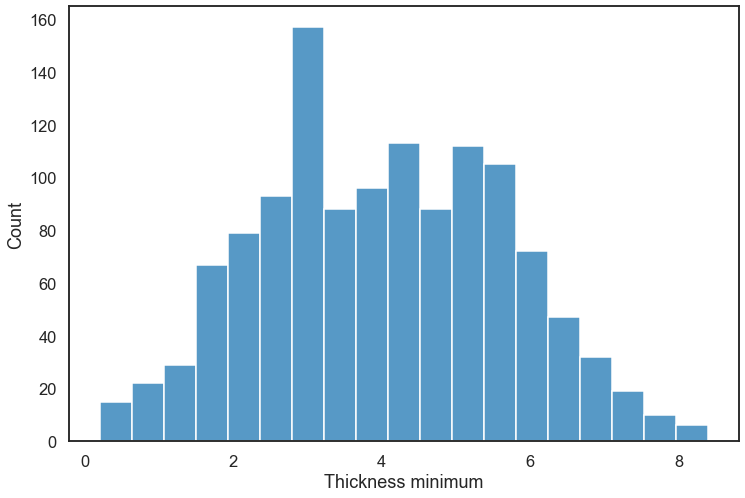

In [28]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness minimum", discrete=False)

plt.show()

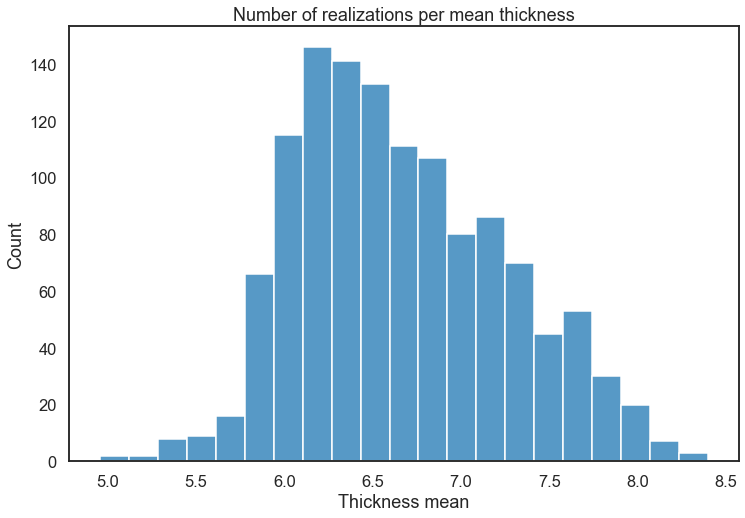

In [29]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

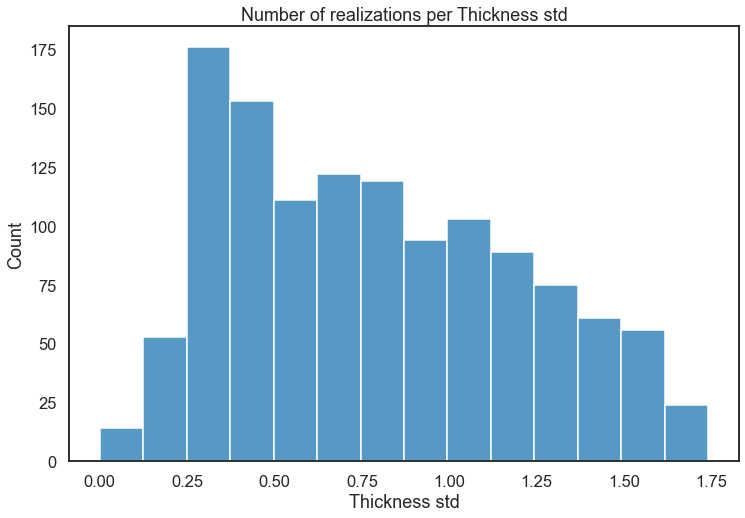

In [30]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness std")
plt.title("Number of realizations per Thickness std")
plt.show()

# Augmentation of idealized cases

In [31]:
labels[(labels['Thickness std'] <= 0.25)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var
0,model_c3456_t032_d000_p002_s1923672703,6.4,1923672703,0.0,0.4,182.003642,13.210036,6.4,6.0,6.203762,6.2,0.146578,0.021485
5,model_c3456_t032_d001_p001_s1895512932,6.4,1895512932,0.2,0.2,199.921400,12.144831,6.4,6.0,6.291088,6.2,0.106470,0.011336
6,model_c3456_t032_d001_p002_s041,6.4,41,0.2,0.4,259.519204,13.687666,6.4,5.8,6.195139,6.2,0.152621,0.023293
7,model_c3456_t032_d001_p004_s1923833840,6.4,1923833840,0.2,0.8,189.191057,11.275563,6.4,5.4,6.069560,6.0,0.229716,0.052769
12,model_c3456_t032_d002_p001_s1885419952,6.4,1885419952,0.4,0.2,205.749103,10.205331,6.4,5.8,6.287847,6.2,0.120647,0.014556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,model_c3456_t042_d001_p000_s100,8.4,100,0.2,0.0,360.600748,32.269551,8.4,8.2,8.378067,8.4,0.062503,0.003907
1138,model_c3456_t042_d001_p002_s1871366522,8.4,1871366522,0.2,0.4,190.779908,87.600202,8.4,7.8,8.142245,8.2,0.172353,0.029705
1139,model_c3456_t042_d001_p003_s1890638651,8.4,1890638651,0.2,0.6,198.985377,83.731606,8.4,7.6,8.080556,8.0,0.215125,0.046279
1140,model_c3456_t042_d001_p003_s1890897780,8.4,1890897780,0.2,0.6,190.940650,83.425144,8.4,7.6,8.069792,8.0,0.208729,0.043568


In [32]:
cases_low_std = labels[(labels['Thickness std'] < 0.25)].index.tolist()

# ML

In [33]:
#x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)
if data_augmentation:
  X_sample_low_std_c = np.squeeze(X_sample_c[cases_low_std, :, :, :])
  X_sample_low_std_4times_c = np.concatenate((X_sample_low_std_c, X_sample_low_std_c, X_sample_low_std_c, X_sample_low_std_c))
  np.random.shuffle(X_sample_low_std_4times_c)
  X_sample_low_std_4times_n = X_sample_low_std_4times_c + make_noise(noisedb, X_sample_low_std_4times_c.shape)

  X_sample_low_std_4times_c = np.expand_dims(X_sample_low_std_4times_c, 1)
  X_sample_low_std_4times_n = np.expand_dims(X_sample_low_std_4times_n, 1)

  X_sample_c_autoencode = np.concatenate((X_sample_c, X_sample_low_std_4times_c))
  X_sample_n_autoencode = np.concatenate((X_sample_n, X_sample_low_std_4times_n))
  x_train, x_test, y_train, y_test = train_test_split(X_sample_n_autoencode, X_sample_c_autoencode, test_size=0.2, random_state=42)
else:
  x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)

In [34]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

Epoch 1/100
4/4 [==============================] - 8s 1s/step - loss: 0.0134 - val_loss: 0.0097
Epoch 2/100
4/4 [==============================] - 2s 540ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 3/100
4/4 [==============================] - 2s 445ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 4/100
4/4 [==============================] - 2s 511ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 5/100
4/4 [==============================] - 2s 561ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/100
4/4 [==============================] - 2s 462ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/100
4/4 [==============================] - 2s 442ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/100
4/4 [==============================] - 2s 521ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/100
4/4 [==============================] - 2s 655ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/100
4/4 [==============================] - 3s 709ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 11/100

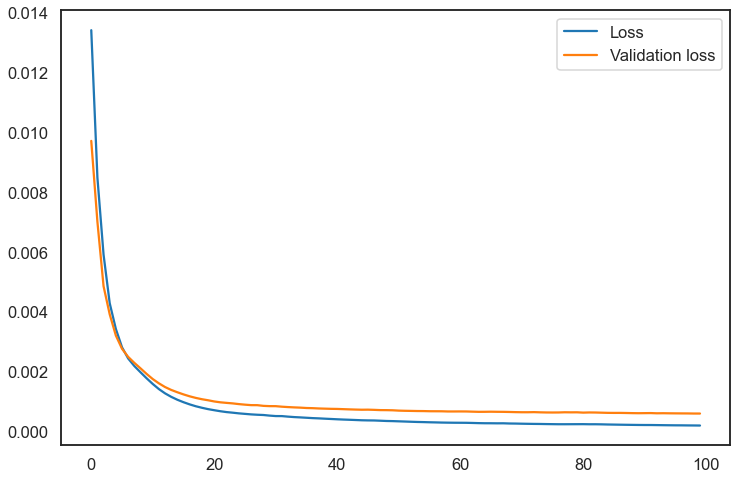

In [35]:
autoencoder_tx, encoder_tx = make_autoencoder(input_dim=x_train_flat.shape[1], encoding_dim=encoding_dim, activation='tanh')
autoencoder_tx.compile(optimizer='adam', loss='mse')

history = autoencoder_tx.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [36]:
autoencoder_tx.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4400)]            0         
                                                                 
 dense (Dense)               (None, 1024)              4506624   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

In [37]:
decoded_traces = autoencoder_tx.predict(x_test_flat)
encoded_traces = encoder_tx.predict(x_test_flat)

8/8 [==============================] - 0s 7ms/step


In [38]:
encoded_traces.shape, decoded_traces.shape

((250, 64), (250, 4400))

In [39]:
test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3])

In [40]:
x_test.shape, test_decoded_shaped.shape

((250, 1, 11, 400), (250, 1, 11, 400))

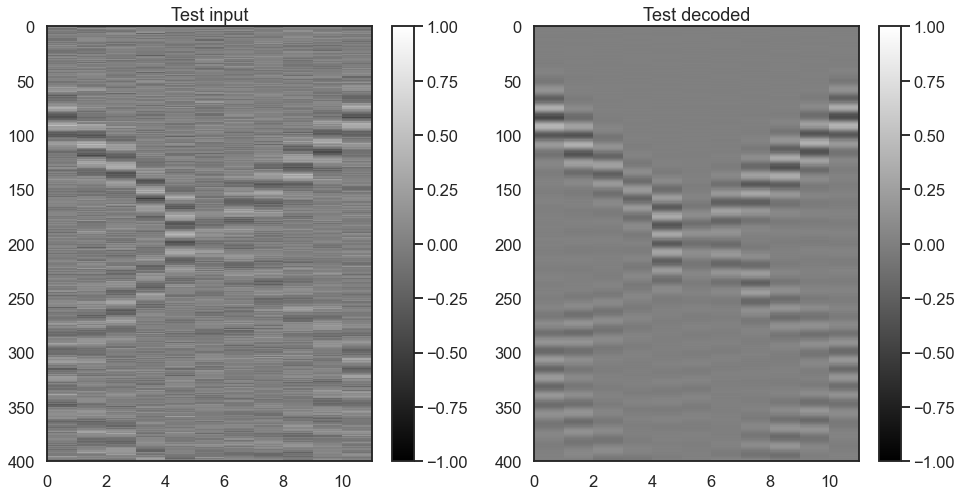

In [41]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

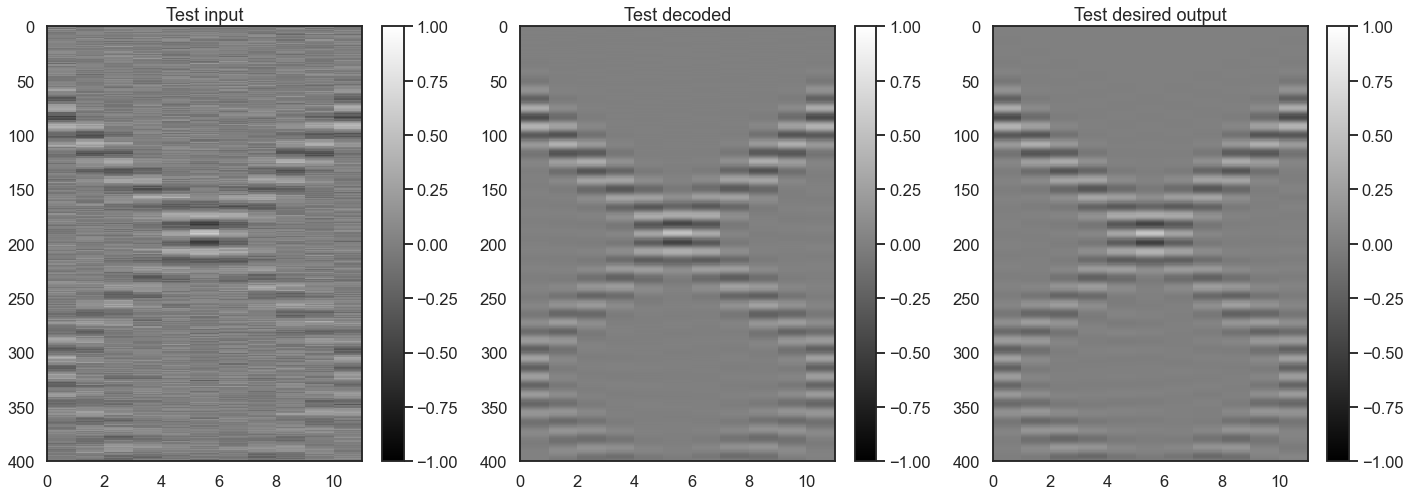

In [42]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test desired output')



plt.show()

In [43]:
autoencoder_tx.evaluate(x_test_flat, x_test_flat)

8/8 [==============================] - 0s 19ms/step - loss: 0.0045


0.00450502336025238

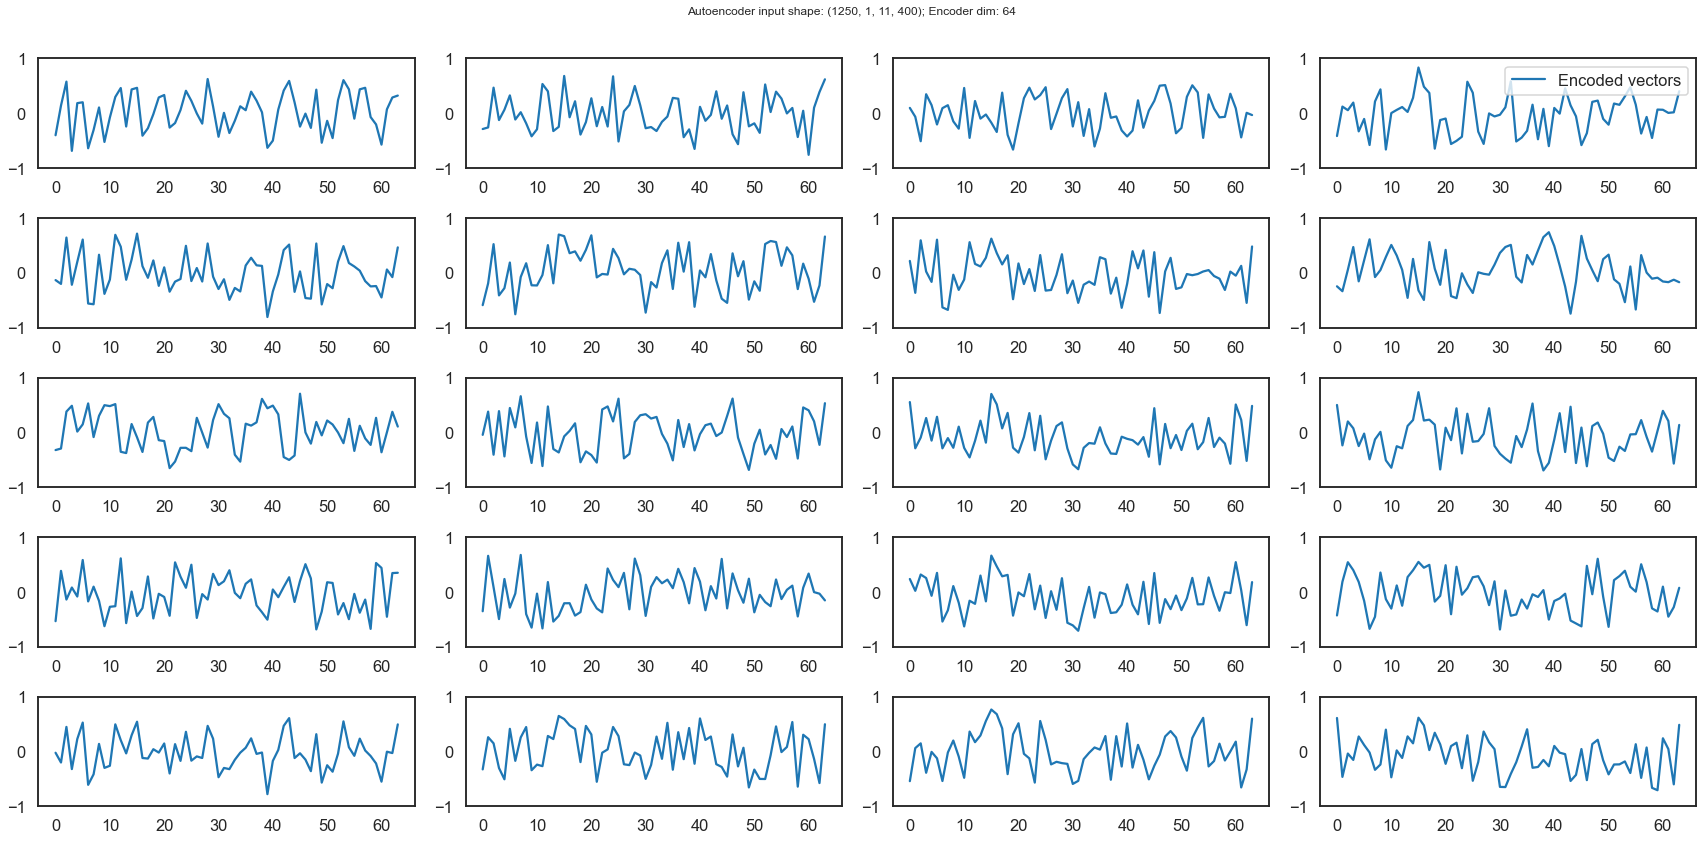

In [44]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)

    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

## Regression

In [45]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))
X_sample_flat.shape

(1250, 4400)

In [47]:
encoded_all = encoder_tx.predict(X_sample_flat)

40/40 [==============================] - 1s 15ms/step


In [48]:
#attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression location','Pitting depth']
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width','Pitting depth']

Thickness mean
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 13ms/step - loss: 0.1858 - val_loss: 0.1074
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0879 - val_loss: 0.0794
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0676 - val_loss: 0.0684
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0588 - val_loss: 0.0628
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0633
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0577
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0567
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0584
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0589
Epoch 10/50
50/50

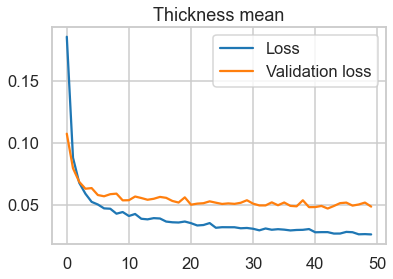

8/8 [==============================] - 0s 3ms/step - loss: 0.0484
loss: 0.04836387187242508
Thickness minimum
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 7ms/step - loss: 0.2505 - val_loss: 0.1792
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1492 - val_loss: 0.1452
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1257 - val_loss: 0.1329
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.1260
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1019 - val_loss: 0.1200
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0934 - val_loss: 0.1134
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.1116
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0877 - val_loss: 0.1091
Epoch 9/50
50/50 [===

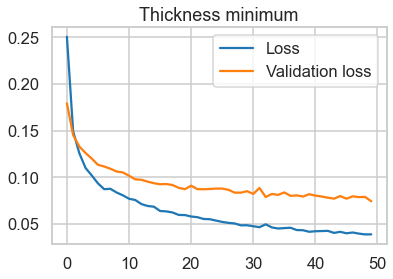

8/8 [==============================] - 0s 2ms/step - loss: 0.0743
loss: 0.074273981153965
Thickness std
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 1s 7ms/step - loss: 0.2529 - val_loss: 0.2018
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1709 - val_loss: 0.1808
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1451 - val_loss: 0.1624
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.1471
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1135 - val_loss: 0.1424
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.1277
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0977 - val_loss: 0.1222
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0892 - val_loss: 0.1211
Epoch 9/50
50/50 [=========

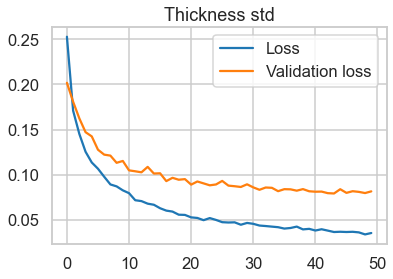

8/8 [==============================] - 0s 2ms/step - loss: 0.0815
loss: 0.08150920271873474
Depression depth
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 4s 21ms/step - loss: 0.3145 - val_loss: 0.2466
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2445 - val_loss: 0.2309
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2233 - val_loss: 0.2168
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2011 - val_loss: 0.2020
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1789 - val_loss: 0.1824
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1519 - val_loss: 0.1686
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1310 - val_loss: 0.1517
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1197 - val_loss: 0.1461
Epoch 9/50
50/50 [===

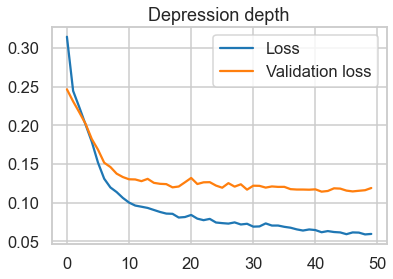

8/8 [==============================] - 0s 2ms/step - loss: 0.1190
loss: 0.11899048835039139
Depression width
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 19ms/step - loss: 0.3172 - val_loss: 0.2189
Epoch 2/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1760 - val_loss: 0.1845
Epoch 3/50
50/50 [==============================] - 0s 10ms/step - loss: 0.1562 - val_loss: 0.1801
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1476 - val_loss: 0.1722
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1412 - val_loss: 0.1689
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1355 - val_loss: 0.1643
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1334 - val_loss: 0.1709
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1272 - val_loss: 0.1605
Epoch 9/50
50/50 [==

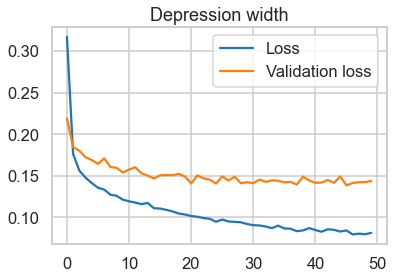

8/8 [==============================] - 0s 2ms/step - loss: 0.1437
loss: 0.14373041689395905
Pitting depth
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 22ms/step - loss: 0.3459 - val_loss: 0.2944
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.2476 - val_loss: 0.2613
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2316 - val_loss: 0.2611
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 0.2249 - val_loss: 0.2524
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2177 - val_loss: 0.2539
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2125 - val_loss: 0.2552
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2080 - val_loss: 0.2478
Epoch 8/50
50/50 [==============================] - 0s 6ms/step - loss: 0.2044 - val_loss: 0.2445
Epoch 9/50
50/50 [======

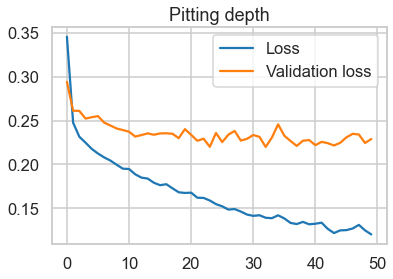

8/8 [==============================] - 0s 2ms/step - loss: 0.2291
loss: 0.22908657789230347


In [50]:
df_loss, df_test, df_predict, autoencoder_regression_models_tx, min_max_scalers = do_regression(encoded_all, label_sample, attributes)

In [52]:
autoencoder_regression_models_tx['Thickness mean'].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 4)                 36        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________


In [53]:
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25]])
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [0, 100],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

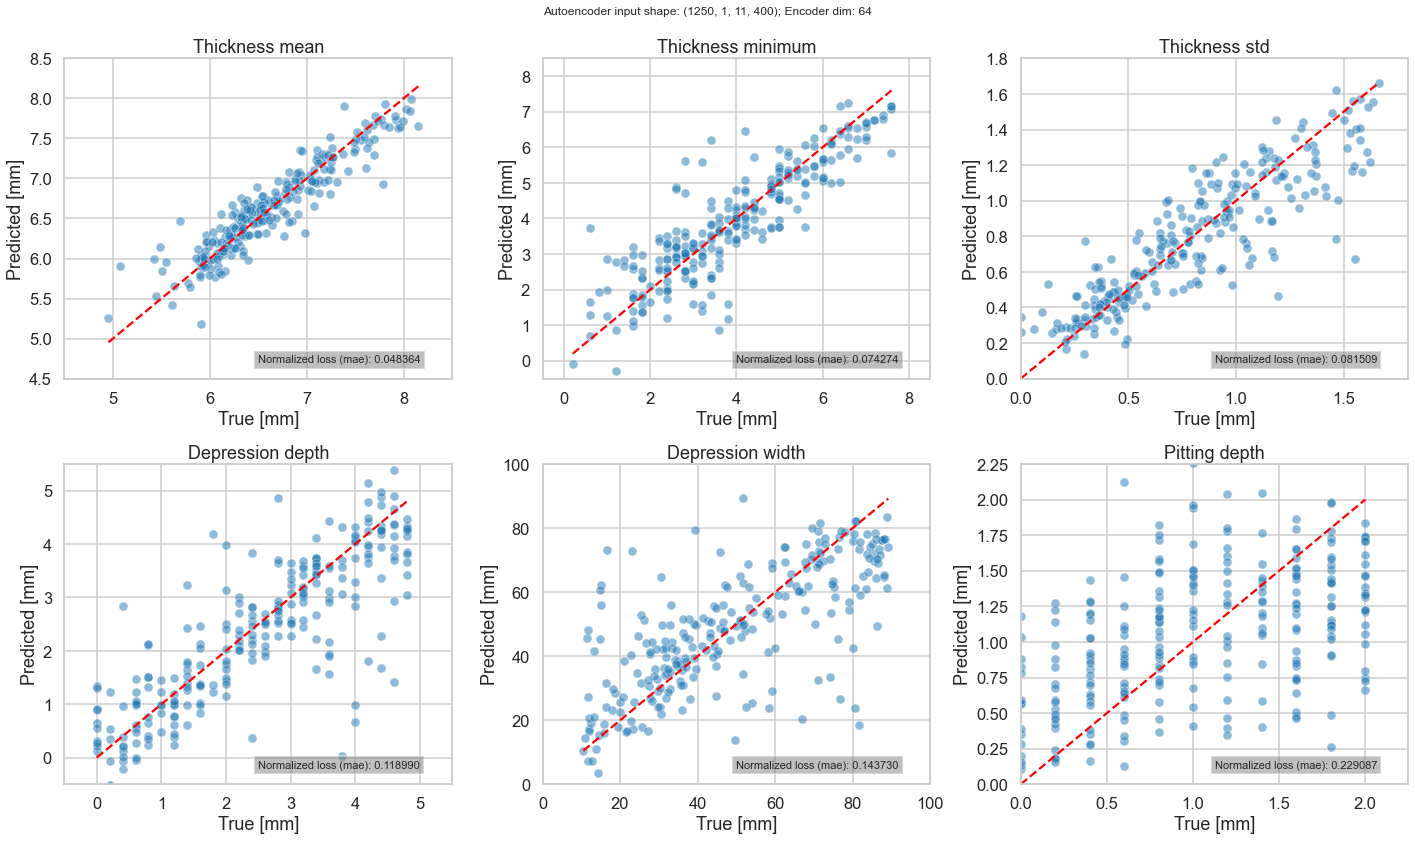

In [55]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim))

## Direct Regression

In [56]:
X_sample_n.shape

(1250, 1, 11, 400)

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 11ms/step - loss: 0.1186 - val_loss: 0.0666
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0555 - val_loss: 0.0549
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0425 - val_loss: 0.0510
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0356 - val_loss: 0.0496
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0290 - val_loss: 0.0485
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0282 - val_loss: 0.0462
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0455
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0207 - val_loss: 0.0494
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0196 - val_loss: 0.

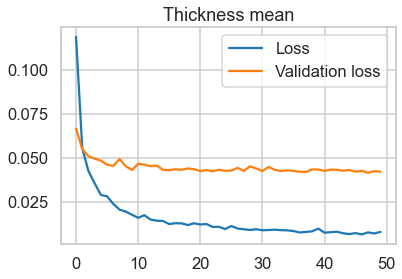

8/8 [==============================] - 0s 5ms/step - loss: 0.0422
loss: 0.04218778386712074
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 14ms/step - loss: 0.1736 - val_loss: 0.1248
Epoch 2/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0901 - val_loss: 0.0995
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0696 - val_loss: 0.0925
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0537 - val_loss: 0.0826
Epoch 5/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0474 - val_loss: 0.0826
Epoch 6/50
50/50 [==============================] - 0s 9ms/step - loss: 0.0414 - val_loss: 0.0791
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0797
Epoch 8/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0307 - val_loss: 0.074

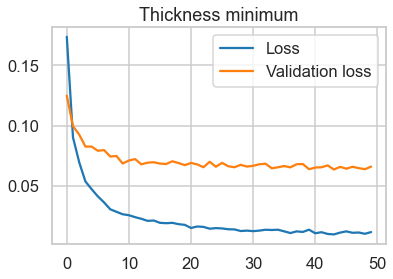

8/8 [==============================] - 0s 5ms/step - loss: 0.0660
loss: 0.06604228168725967
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 4s 22ms/step - loss: 0.2105 - val_loss: 0.1546
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1146 - val_loss: 0.1142
Epoch 3/50
50/50 [==============================] - 0s 10ms/step - loss: 0.0828 - val_loss: 0.0993
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0622 - val_loss: 0.0947
Epoch 5/50
50/50 [==============================] - 1s 19ms/step - loss: 0.0557 - val_loss: 0.0940
Epoch 6/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0445 - val_loss: 0.0910
Epoch 7/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0401 - val_loss: 0.0846
Epoch 8/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0347 - val_loss: 0.0

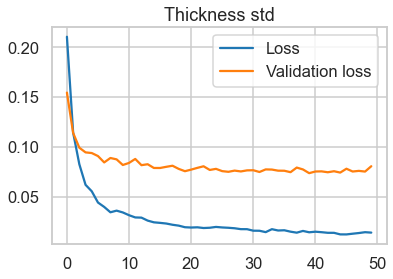

8/8 [==============================] - 0s 4ms/step - loss: 0.0808
loss: 0.08082051575183868
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 3s 25ms/step - loss: 0.3381 - val_loss: 0.2480
Epoch 2/50
50/50 [==============================] - 1s 13ms/step - loss: 0.1955 - val_loss: 0.1886
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1391 - val_loss: 0.1822
Epoch 4/50
50/50 [==============================] - 1s 13ms/step - loss: 0.1143 - val_loss: 0.1450
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0887 - val_loss: 0.1560
Epoch 6/50
50/50 [==============================] - 1s 16ms/step - loss: 0.0734 - val_loss: 0.1472
Epoch 7/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0695 - val_loss: 0.1508
Epoch 8/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0636 - val_loss:

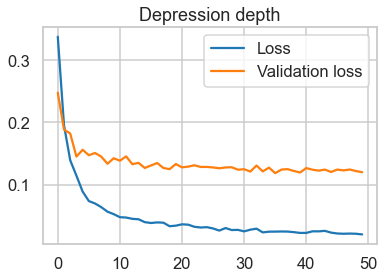

8/8 [==============================] - 0s 4ms/step - loss: 0.1198
loss: 0.1198473796248436
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 3s 19ms/step - loss: 0.2084 - val_loss: 0.1787
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1280 - val_loss: 0.1699
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1052 - val_loss: 0.1639
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0910 - val_loss: 0.1684
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0761 - val_loss: 0.1669
Epoch 6/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0707 - val_loss: 0.1568
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0631 - val_loss: 0.1578
Epoch 8/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0532 - val_loss: 0.15

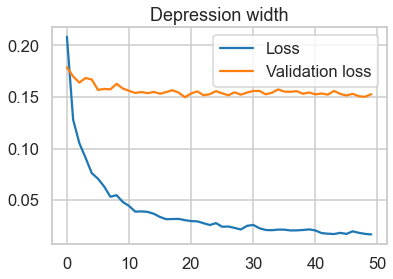

8/8 [==============================] - 0s 4ms/step - loss: 0.1527
loss: 0.15269801020622253
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 13ms/step - loss: 0.3221 - val_loss: 0.2462
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.2266 - val_loss: 0.2489
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1989 - val_loss: 0.2273
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1628 - val_loss: 0.2489
Epoch 5/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1399 - val_loss: 0.2460
Epoch 6/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1156 - val_loss: 0.2373
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0977 - val_loss: 0.2247
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0846 - val_loss: 0.2424
Ep

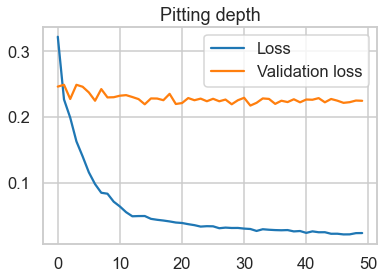

8/8 [==============================] - 0s 3ms/step - loss: 0.2246
loss: 0.22458873689174652


In [57]:
df_loss, df_test, df_predict, direct_regression_models_tx, min_max_scalers = do_regression(X_sample_n, label_sample, attributes)

In [58]:
direct_regression_models_tx['Thickness mean'].summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 64)                281664    
                                                                 
 dense_41 (Dense)            (None, 32)                2080      
                                                                 
 dense_42 (Dense)            (None, 16)                528       
                                                                 
 dense_43 (Dense)            (None, 8)                 136       
                                                                 
 dense_44 (Dense)            (None, 4)                 36        
                                                                 
 dense_45 (Dense)            (None, 1)                 5         
                                                                 
Total params: 284,449
Trainable params: 284,449
Non-tr

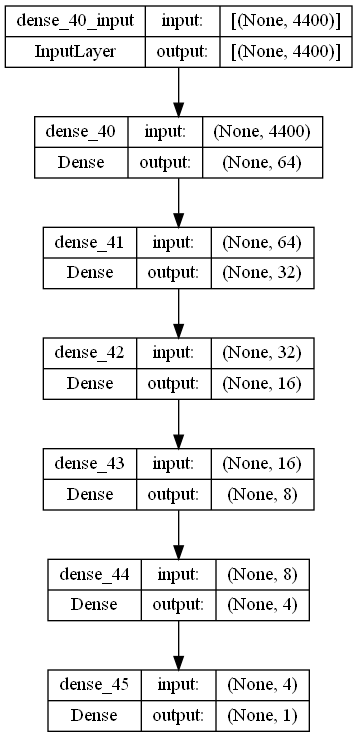

In [59]:
plot_model(direct_regression_models_tx['Thickness mean'], show_shapes=True, show_layer_names=True)

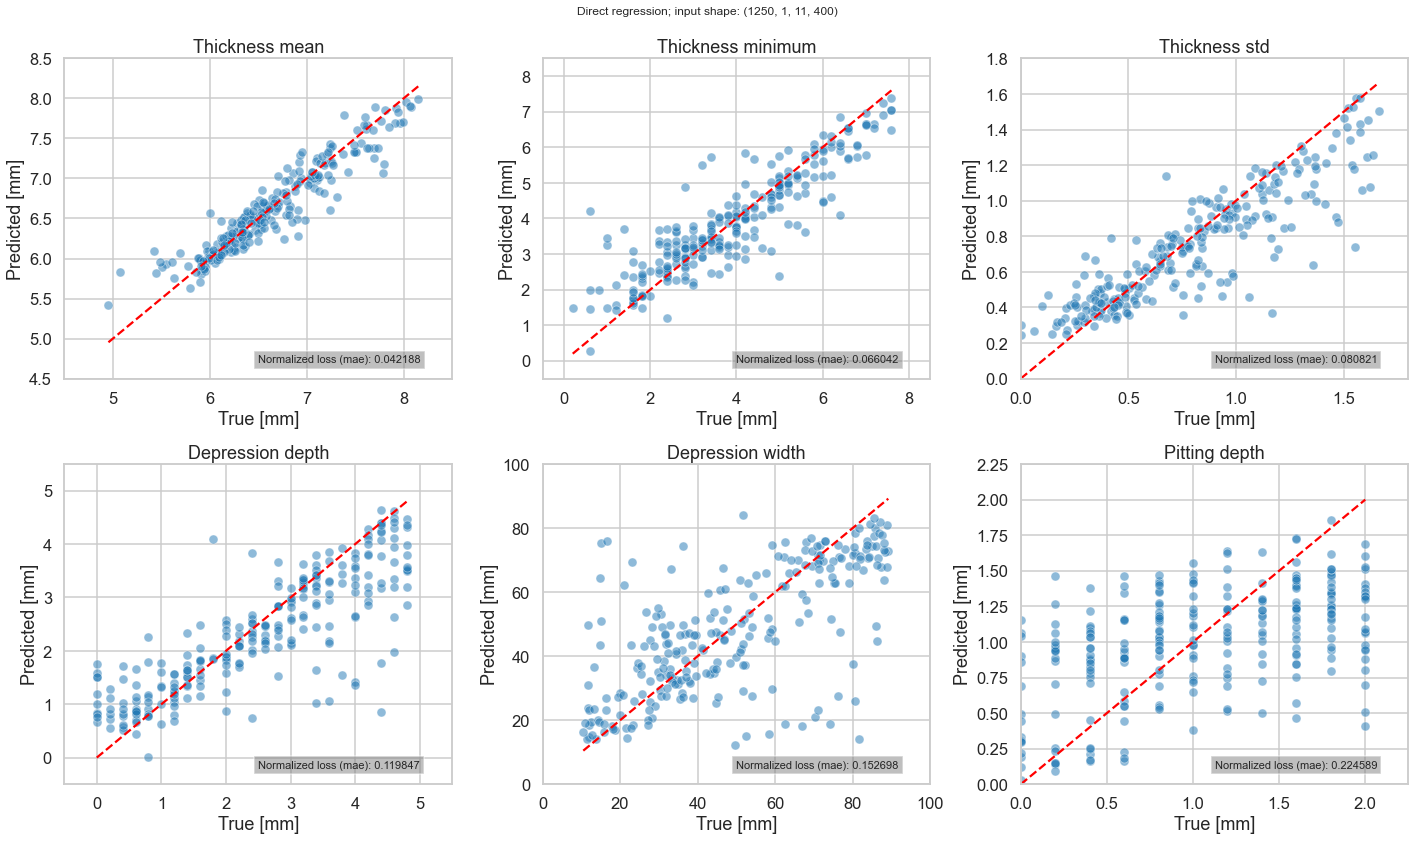

In [61]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct regression; input shape: '+ str(X_sample_n.shape))

# Real data

In [62]:
realdatapath = '../data/input_real/Waveforms_clock_pos/'
df_waveforms, df_time = read_data.read_waveforms(realdatapath)

20220210-01oc-040kHz.csv
20220210-01oc-041kHz.csv
20220210-01oc-042kHz.csv
20220210-01oc-043kHz.csv
20220210-01oc-044kHz.csv
20220210-01oc-045kHz.csv
20220210-01oc-046kHz.csv
20220210-01oc-047kHz.csv
20220210-01oc-048kHz.csv
20220210-01oc-049kHz.csv
20220210-01oc-050kHz.csv
20220210-01oc-051kHz.csv
20220210-01oc-052kHz.csv
20220210-01oc-053kHz.csv
20220210-01oc-054kHz.csv
20220210-01oc-055kHz.csv
20220210-01oc-056kHz.csv
20220210-01oc-057kHz.csv
20220210-01oc-058kHz.csv
20220210-01oc-059kHz.csv
20220210-01oc-060kHz.csv
20220210-01oc-061kHz.csv
20220210-01oc-062kHz.csv
20220210-01oc-063kHz.csv
20220210-01oc-064kHz.csv
20220210-01oc-065kHz.csv
20220210-01oc-066kHz.csv
20220210-01oc-067kHz.csv
20220210-01oc-068kHz.csv
20220210-01oc-069kHz.csv
20220210-01oc-070kHz.csv
20220210-01oc-071kHz.csv
20220210-01oc-072kHz.csv
20220210-01oc-073kHz.csv
20220210-01oc-074kHz.csv
20220210-01oc-075kHz.csv
20220210-01oc-076kHz.csv
20220210-01oc-077kHz.csv
20220210-01oc-078kHz.csv
20220210-01oc-079kHz.csv


In [63]:
first_iter = True
for freq in np.unique(df_waveforms.columns):
  measurement_temp = df_waveforms[freq].to_numpy()[817:4100:5,:-1]
  measurement_temp = measurement_temp/measurement_temp.max()
  if first_iter:
    measurements = np.expand_dims(measurement_temp, axis=0)
    first_iter = False
  else:
    measurements = np.concatenate((measurements, np.expand_dims(measurement_temp, axis=0)), axis=0)

In [64]:
measurements = measurements[:,:timesamples,:]
measurements.shape

(41, 400, 11)

In [65]:
# Filtering
applyfilter = True
if applyfilter:
  for panelno in range(41):
    frq = panelno+40
    cutoff = frq*1.2*1000
    filtered_temp = butter_lowpass_filter(measurements[panelno], cutoff, 4)
    measurements[panelno] = filtered_temp/filtered_temp.max()

In [66]:
measurements.max()

1.0

In [67]:
tracebalancing = False
if tracebalancing:
  for panelno in range(41):
    tracemax = np.zeros(shape=measurements[panelno,1,:].shape)
    for traceno in range(len(tracemax)):
      tracemax[traceno] = measurements[panelno,:,traceno].max()
    measurements[panelno] = np.divide(measurements[panelno], tracemax)

In [68]:
add_noise_to_measurement = False # Set to False if added in FK instead
if add_noise_to_measurement:
  measurements = measurements + make_noise(noisedb, measurements.shape)


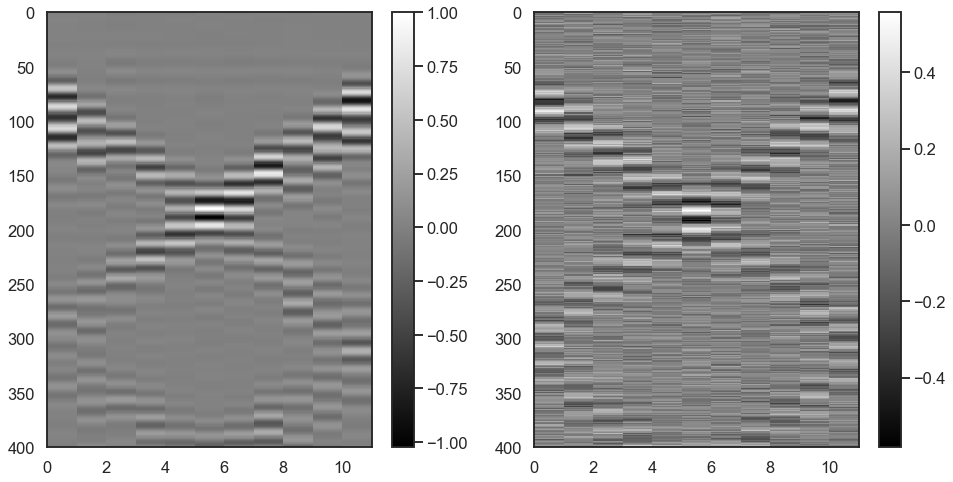

In [69]:
sns.set_style('white')
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.pcolormesh(measurements[20,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[679,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [71]:
measurements_flat = measurements.reshape((len(measurements), np.prod(measurements.shape[1:])))
real_autoencoded = autoencoder_tx.predict(measurements_flat)

2/2 [==============================] - 0s 6ms/step


In [72]:
real_autoencoded.shape, measurements.shape

((41, 4400), (41, 400, 11))

In [73]:
real_autoencoded_shaped = real_autoencoded.reshape(41, 11, timesamples)
real_autoencoded_shaped.shape

(41, 11, 400)

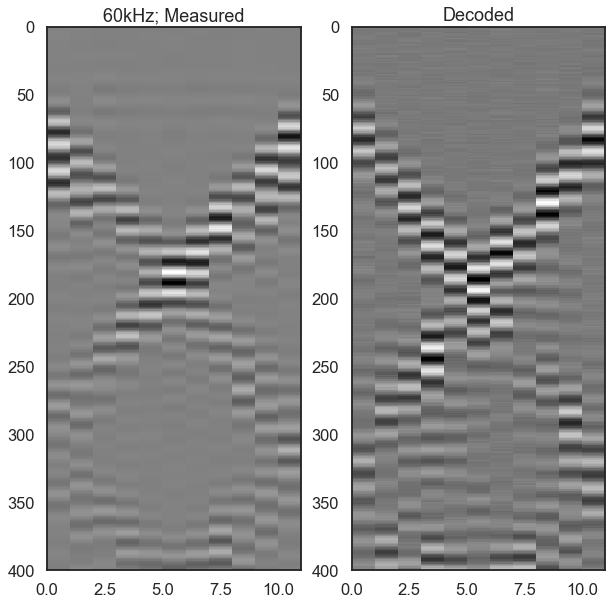

In [74]:
freq = 60
sns.set_style('white')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolormesh(measurements[freq-40,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.title(str(freq) + 'kHz; Measured')
plt.subplot(1,2,2)
plt.pcolormesh(real_autoencoded_shaped[freq-40,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('Decoded')
plt.show()

In [ ]:
#stop

In [75]:
real_encoded = encoder_tx.predict(measurements_flat)

2/2 [==============================] - 0s 9ms/step


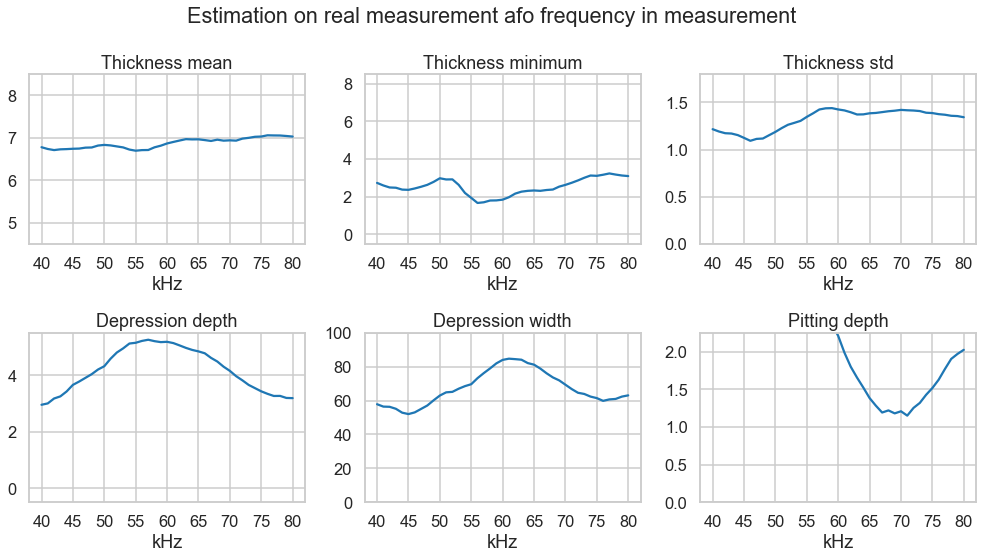

In [76]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
plt.figure(figsize=(14, 8))
for i, attribute in enumerate(attributes):
  real_prediction_norm = autoencoder_regression_models_tx[attribute](real_encoded)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.subplot(2,3, i+1)
  plt.plot(real_prediction[attribute])
  plt.ylim([df_scales[attribute][0], df_scales[attribute][1]])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
plt.suptitle('Estimation on real measurement afo frequency in measurement')
plt.tight_layout()
plt.show()

# FK

In [81]:
def make_fk_samples(X, dt, dx, fk_minfreq=20e3, fk_maxfreq=100e3, returncomplex=False, returndb=False):
  X_fk = np.zeros(shape=X.shape)
  X_fk = np.swapaxes(X_fk, 2, 3)
  X_fk = np.expand_dims(X_fk, 2)
  X_fk = np.repeat(X_fk, 2, axis=2)
  print(X_fk.shape)
  for i in range(X_fk.shape[0]):
    for j in range(X_fk.shape[1]):
      if returncomplex:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_real = np.real(fk_temp)
        fk_temp_im = np.imag(fk_temp)
        X_fk[i,j,0,:,:] = fk_temp_real/400
        X_fk[i,j,1,:,:] = fk_temp_im/400

      else:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_amp = np.abs(fk_temp)#/np.max(np.abs(fk_temp))
        if returndb:
          fk_temp_amp = 20*np.log10(fk_temp_amp)
        fk_temp_amp = minmax_scale(fk_temp_amp)
        fk_temp_angle = np.unwrap(np.angle(fk_temp))
        fk_temp_angle = minmax_scale(fk_temp_angle)
        X_fk[i,j,0,:,:] = fk_temp_amp
        X_fk[i,j,1,:,:] = fk_temp_angle



  #fk_maxfreq = 120e3
  fk_f_indeces = np.where((f_array >= fk_minfreq) & (f_array <= fk_maxfreq))

  f_array = f_array[fk_f_indeces[0]]
  X_fk = X_fk[:,:,:,fk_f_indeces[0],:]

  return X_fk, x_array, f_array

In [82]:
X_sample_n_fk, x_array, f_array = make_fk_samples(X_sample_n, dt, dx, returndb=False)
X_sample_c_fk, x_array, f_array = make_fk_samples(X_sample_c, dt, dx, returndb=False)

(1250, 1, 2, 400, 11)
(1250, 1, 2, 400, 11)


In [83]:
X_sample_n_fk.shape

(1250, 1, 2, 33, 11)

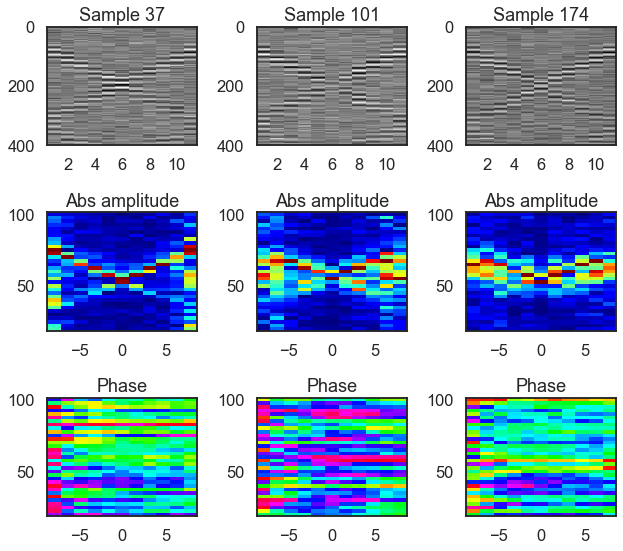

In [84]:
cases = [37, 101, 174]
clock_array = np.array([2, 4, 6, 8, 10])
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(3*len(cases),8))
for i, case in enumerate(cases):
  plt.subplot(3, len(cases), i+1)
  #plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet')
  plt.pcolormesh(X_sample_n[case,0,:,:].T, cmap='gray')
  plt.gca().invert_yaxis()
  plt.xticks(ticks=clock_array-0.5, labels=clock_array)
  #plt.title('Sample ' + str(case) + '; Thickness min: ' + str(np.round(labels.iloc[case]['Thickness minimum']*0.2, decimals=1)))

  plt.title('Sample ' + str(case))
  plt.subplot(3, len(cases), i+len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,0,:,:], cmap='jet')
  plt.title('Abs amplitude')
  #plt.colorbar()
  plt.subplot(3, len(cases), i+2*len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,1,:,:], cmap='hsv')
  plt.title('Phase')
  #plt.colorbar()
  #plt.colorbar()
plt.tight_layout()
plt.show()

In [85]:
amp_only = True
if amp_only:
  X_sample_n_fk = X_sample_n_fk[:,:,0,:,:]
  X_sample_c_fk = X_sample_c_fk[:,:,0,:,:]

In [86]:
def make_fk_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.random(size=noiseshape)*noiselev
  return noise

In [87]:
X_sample_c_n_fk = X_sample_c_fk + make_fk_noise(noisedb, X_sample_c_fk.shape)

In [88]:
labels.iloc[230]

modelname              model_c3456_t034_d000_p000_s1865765870
Thickness                                                 6.8
seed                                               1865765870
Depression depth                                          0.0
Pitting depth                                             0.0
Depression location                                 182.83797
Depression width                                    30.030635
Thickness maximum                                         6.8
Thickness minimum                                         6.8
Thickness mean                                            6.8
Thickness median                                          6.8
Thickness std                                             0.0
thickness_var                                             0.0
Name: 230, dtype: object

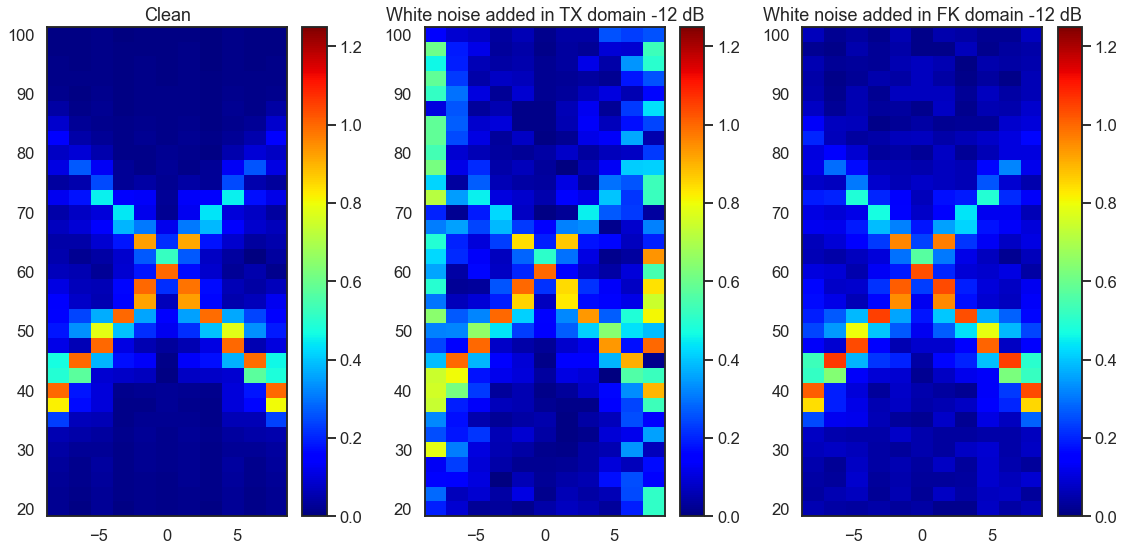

In [89]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title('Clean')
plt.subplot(1,3,2)
plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title(f'White noise added in TX domain {noisedb} dB')
plt.subplot(1,3,3)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title(f'White noise added in FK domain {noisedb} dB')
plt.tight_layout()
plt.show()

In [90]:
X_sample_n_fk = X_sample_c_n_fk

In [91]:
X_sample_n_fk.shape, X_sample_n_fk.max(), X_sample_c_fk.shape

((1250, 1, 33, 11), 1.0630927491541358, (1250, 1, 33, 11))

In [92]:
if data_augmentation:
  X_sample_c_autoencode_fk, x_array, f_array = make_fk_samples(X_sample_c_autoencode, dt, dx, returndb=False)
  X_sample_n_autoencode_fk, x_array, f_array = make_fk_samples(X_sample_n_autoencode, dt, dx, returndb=False)
  X_sample_c_autoencode_fk.shape, X_sample_n_autoencode_fk.shape
  if amp_only:
    X_sample_c_autoencode_fk = X_sample_c_autoencode_fk[:,:,0,:,:]
    X_sample_n_autoencode_fk = X_sample_n_autoencode_fk[:,:,0,:,:]
  x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_autoencode_fk, X_sample_c_autoencode_fk, test_size=0.2, random_state=42)
else:
  x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_fk, X_sample_c_fk, test_size=0.2, random_state=42)

In [93]:
x_train_flat_fk = x_train_fk.reshape((len(x_train_fk), np.prod(x_train_fk.shape[1:])))
x_test_flat_fk = x_test_fk.reshape((len(x_test_fk), np.prod(x_test_fk.shape[1:])))
y_train_flat_fk = y_train_fk.reshape((len(y_train_fk), np.prod(y_train_fk.shape[1:])))
y_test_flat_fk = y_test_fk.reshape((len(y_test_fk), np.prod(y_test_fk.shape[1:])))

In [94]:
x_train_flat_fk.shape, x_test_flat_fk.shape, y_train_flat_fk.shape, y_test_flat_fk.shape

((1000, 363), (250, 363), (1000, 363), (250, 363))

# Direct Regression in FK

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 1s 13ms/step - loss: 0.1013 - val_loss: 0.0656
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0526 - val_loss: 0.0538
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0509
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0478
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0427 - val_loss: 0.0513
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0497
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0510
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0482
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.

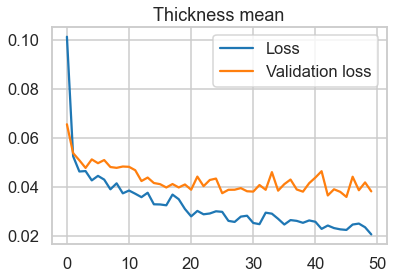

8/8 [==============================] - 0s 2ms/step - loss: 0.0382
loss: 0.03823556751012802
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 1s 8ms/step - loss: 0.1422 - val_loss: 0.0805
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0685 - val_loss: 0.0655
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0595
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0524 - val_loss: 0.0534
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0480 - val_loss: 0.0509
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0466 - val_loss: 0.0489
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0450 - val_loss: 0.0503
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0406 - val_loss: 0.0465

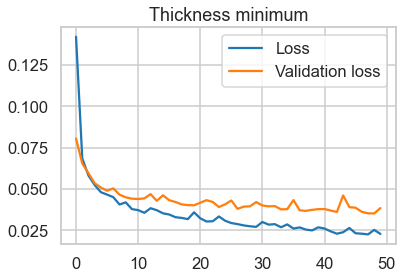

8/8 [==============================] - 0s 2ms/step - loss: 0.0384
loss: 0.03840415179729462
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 1s 6ms/step - loss: 0.1611 - val_loss: 0.1042
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0866 - val_loss: 0.0819
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0749 - val_loss: 0.0743
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0642 - val_loss: 0.0682
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0541
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0602
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0684
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0482
Epo

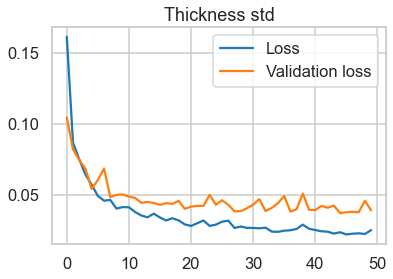

8/8 [==============================] - 0s 2ms/step - loss: 0.0389
loss: 0.038867492228746414
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 1s 7ms/step - loss: 0.1590 - val_loss: 0.0983
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0918 - val_loss: 0.0887
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0798 - val_loss: 0.0869
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0725 - val_loss: 0.0871
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0734 - val_loss: 0.0867
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0686 - val_loss: 0.0759
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0936
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0806

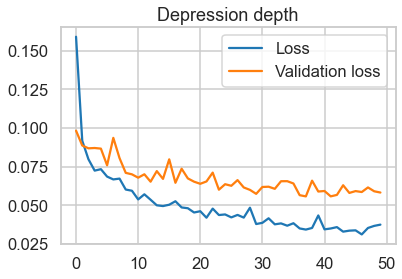

8/8 [==============================] - 0s 2ms/step - loss: 0.0583
loss: 0.058283425867557526
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 1s 7ms/step - loss: 0.2143 - val_loss: 0.1825
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1671 - val_loss: 0.1770
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1496 - val_loss: 0.1791
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1462 - val_loss: 0.1652
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1417 - val_loss: 0.1591
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1410 - val_loss: 0.1590
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1345 - val_loss: 0.1574
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1299 - val_loss: 0.1480

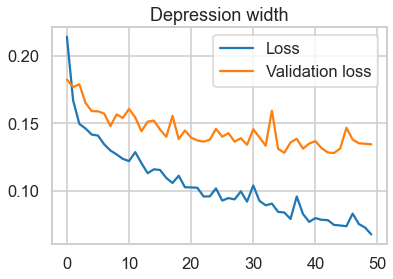

8/8 [==============================] - 0s 2ms/step - loss: 0.1345
loss: 0.1344711035490036
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 10ms/step - loss: 0.2874 - val_loss: 0.2403
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2426 - val_loss: 0.2413
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2393 - val_loss: 0.2376
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2264 - val_loss: 0.2373
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2205 - val_loss: 0.2353
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2274 - val_loss: 0.2446
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2126 - val_loss: 0.2323
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2144 - val_loss: 0.2323
Epo

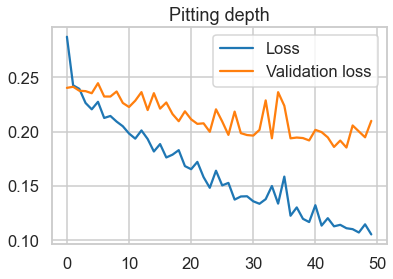

8/8 [==============================] - 0s 4ms/step - loss: 0.2099
loss: 0.2098803073167801


In [99]:
df_loss, df_test, df_predict, direct_regression_models_fk, min_max_scalers = do_regression(X_sample_n_fk, label_sample, attributes)

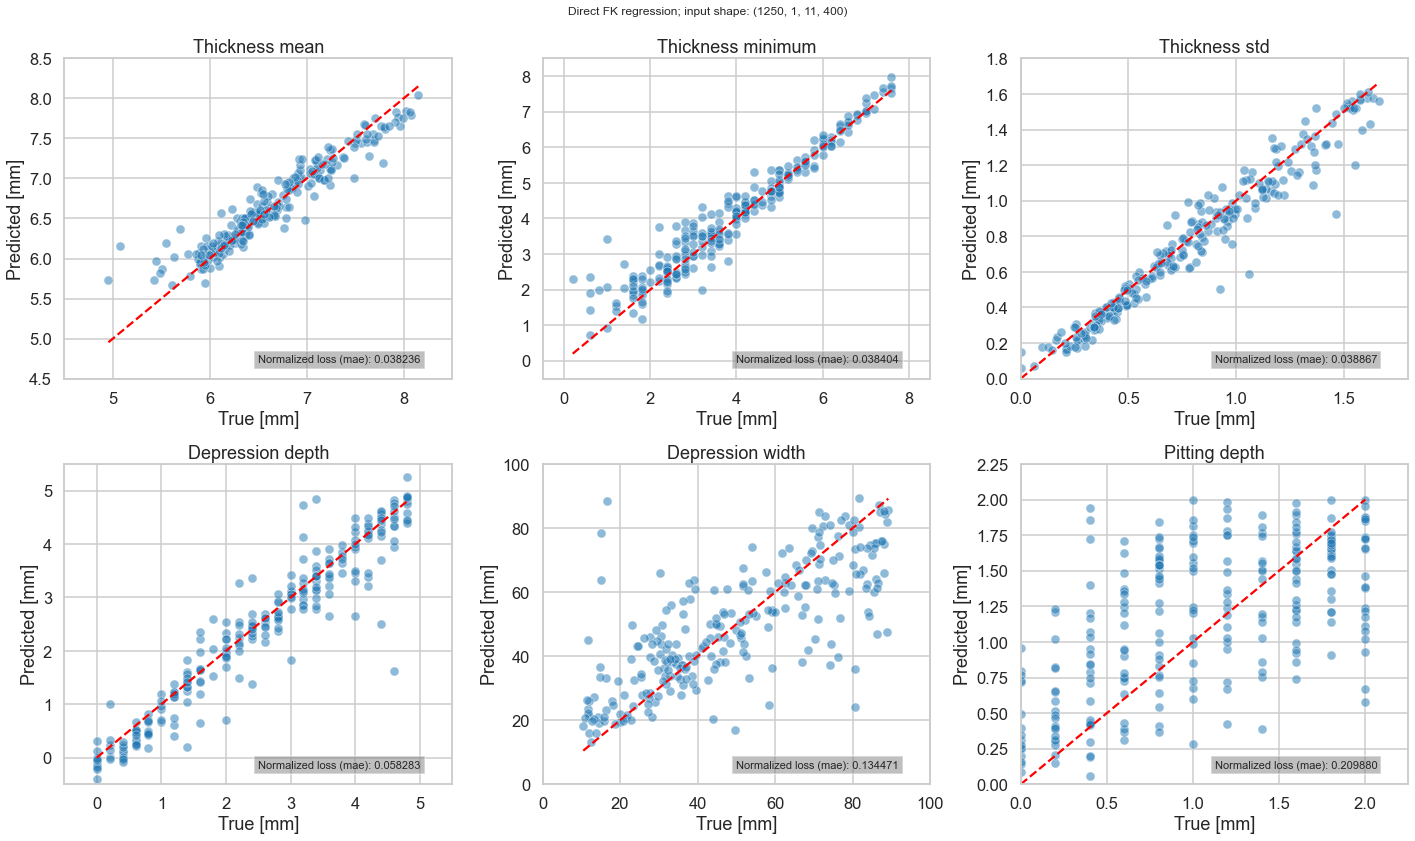

In [101]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct FK regression; input shape: '+ str(X_sample_n.shape))

In [102]:
measurements_mod = measurements.swapaxes(1,2)


In [103]:
measurements_mod = np.expand_dims(measurements_mod, 1)

In [104]:
measurements_mod.shape, X_sample_n.shape

((41, 1, 11, 400), (1250, 1, 11, 400))

In [105]:
measurements_fk, x_array, f_array = make_fk_samples(measurements_mod, dt, dx, returndb=False)

(41, 1, 2, 400, 11)


In [106]:
if amp_only:
  measurements_fk = measurements_fk[:,:,0,:,:]

In [107]:
add_noise_to_fk_measurement = True
if add_noise_to_fk_measurement:
  measurements_fk = measurements_fk + make_fk_noise(noisedb, measurements_fk.shape)

In [108]:
measurements_flat_fk = measurements_fk.reshape((len(measurements_fk), np.prod(measurements_fk.shape[1:])))

In [109]:
measurements_flat_fk.shape

(41, 363)

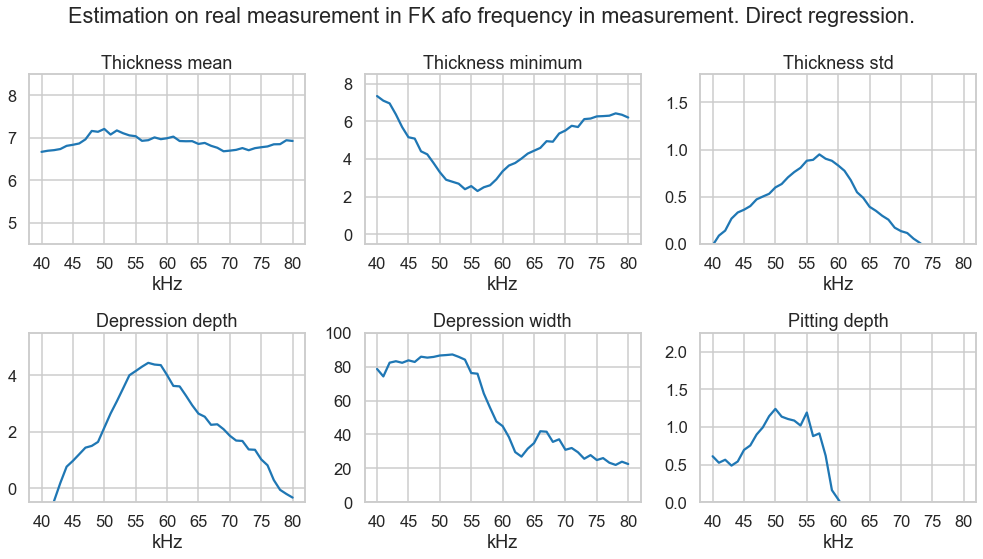

In [110]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
plt.figure(figsize=(14, 8))
for i, attribute in enumerate(attributes):
  real_prediction_norm = direct_regression_models_fk[attribute](measurements_flat_fk)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.subplot(2,3, i+1)
  plt.plot(real_prediction[attribute])
  plt.ylim([df_scales[attribute][0], df_scales[attribute][1]])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
plt.suptitle('Estimation on real measurement in FK afo frequency in measurement. Direct regression.')
plt.tight_layout()
plt.show()

# Autoencoder in FK

Epoch 1/100
4/4 [==============================] - 3s 183ms/step - loss: 0.0866 - val_loss: 0.0853
Epoch 2/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0816 - val_loss: 0.0775
Epoch 3/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0722 - val_loss: 0.0650
Epoch 4/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0594 - val_loss: 0.0516
Epoch 5/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0472 - val_loss: 0.0413
Epoch 6/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0382 - val_loss: 0.0341
Epoch 7/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0322 - val_loss: 0.0298
Epoch 8/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0288 - val_loss: 0.0274
Epoch 9/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0269 - val_loss: 0.0261
Epoch 10/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0259 - val_loss: 0.0254
Epoch 11/100
4/4 [

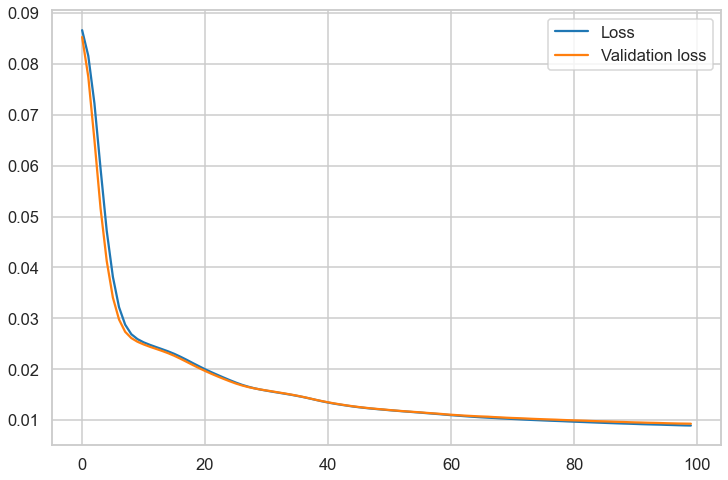

In [119]:
autoencoder_fk, encoder_fk = make_autoencoder(input_dim=x_train_flat_fk.shape[1], encoding_dim=16, activation='relu') #was 24
autoencoder_fk.compile(optimizer='adam', loss='mse')

history = autoencoder_fk.fit(x_train_flat_fk, y_train_flat_fk,
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_flat_fk, y_test_flat_fk))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [118]:
int(np.floor(np.log(x_train_flat_fk.shape[1]/32)/np.log(2)))

3

In [120]:
decoded_traces_fk = autoencoder_fk.predict(x_test_flat_fk)
encoded_traces_fk = encoder_fk.predict(x_test_flat_fk)

8/8 [==============================] - 0s 3ms/step


In [121]:
decoded_shaped_fk = decoded_traces_fk.reshape(len(decoded_traces_fk), y_test_fk.shape[1], y_test_fk.shape[2], y_test_fk.shape[3])

In [122]:
decoded_shaped_fk.shape, x_test_fk.shape

((250, 1, 33, 11), (250, 1, 33, 11))

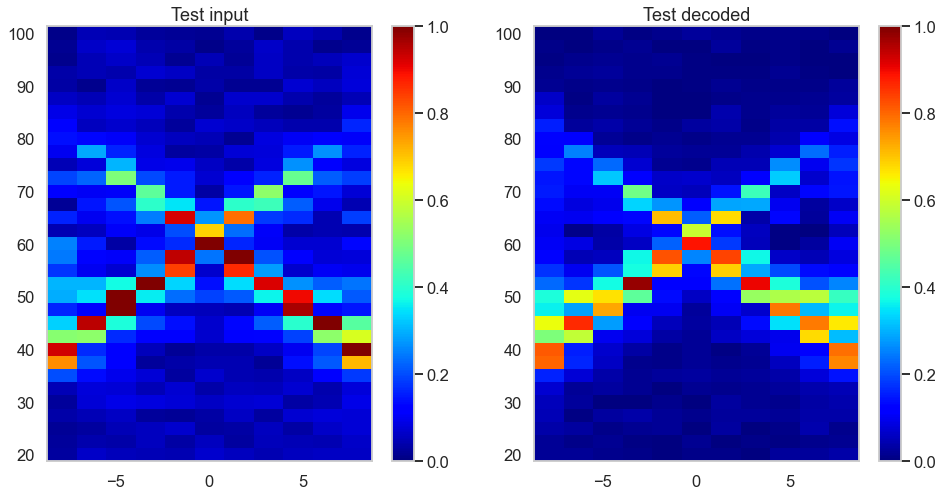

In [123]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_array, f_array/1e3, x_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

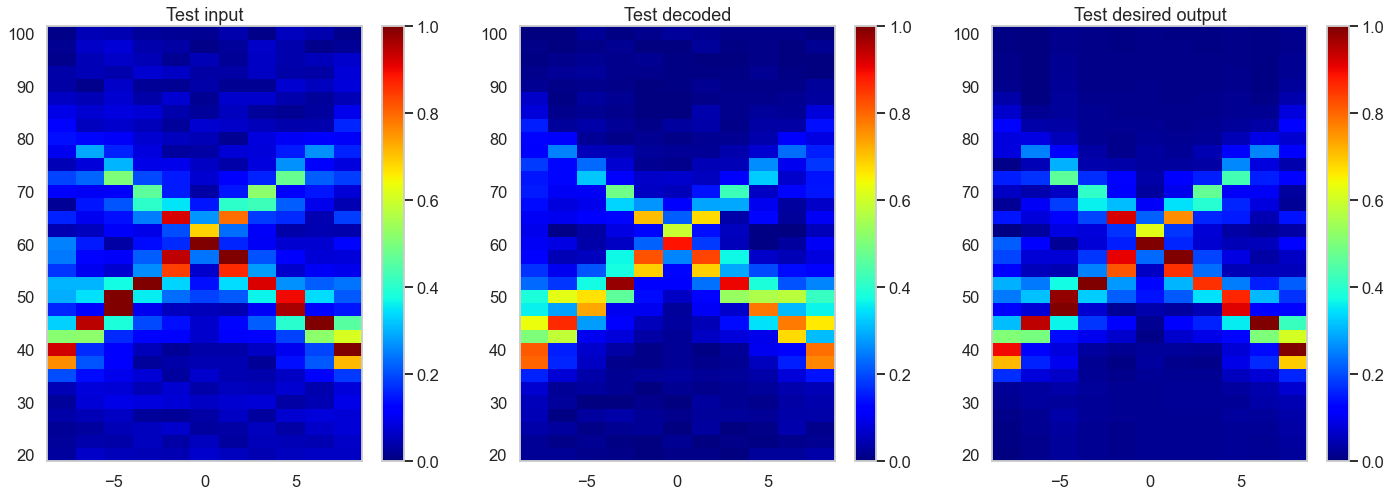

In [124]:
#sampleno = 3
for sampleno in range(0,1):
  plt.figure(figsize=(24,8))

  plt.subplot(1, 3, 1)
  plt.pcolormesh(x_array, f_array/1e3, x_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test input')

  plt.subplot(1, 3, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test decoded')

  plt.subplot(1, 3, 3)
  plt.pcolormesh(x_array, f_array/1e3, y_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test desired output')


  #plt.savefig('./images/simulations_autoencoder_' + str(sampleno).zfill(2) + '.png')
  plt.show()

In [125]:
decoded_measurements_fk = autoencoder_fk.predict(measurements_flat_fk)

2/2 [==============================] - 0s 6ms/step


In [126]:
encoded_measurements_fk = encoder_fk.predict(measurements_flat_fk)

2/2 [==============================] - 0s 6ms/step


In [127]:
decoded_measurements_shaped_fk = decoded_measurements_fk.reshape(len(decoded_measurements_fk), measurements_fk.shape[1], measurements_fk.shape[2], measurements_fk.shape[3])

In [128]:
decoded_measurements_shaped_fk.shape

(41, 1, 33, 11)

In [129]:
for testno in range(20,20):
  plt.figure(figsize=(16,8))

  plt.subplot(1, 2, 1)
  plt.pcolormesh(x_array, f_array/1e3, measurements_fk[testno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Measurement input: '+ str(testno+40) + 'kHz')

  plt.subplot(1, 2, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[testno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Measurement decoded')

  #plt.subplot(1, 3, 3)
  #plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  #plt.colorbar()
  #plt.title('Test desired output')

  #plt.savefig('./images/measurements_encoded_' +str(testno).zfill(2) + '.png')
  plt.show()

In [130]:
X_sample_flat_fk = X_sample_n_fk.reshape((len(X_sample_n_fk), np.prod(X_sample_n_fk.shape[1:])))
X_sample_flat_fk.shape

(1250, 363)

In [131]:
encoded_all_fk = encoder_fk.predict(X_sample_flat_fk)

40/40 [==============================] - 0s 2ms/step


Thickness mean
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 5s 23ms/step - loss: 0.1324 - val_loss: 0.1345
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1179 - val_loss: 0.1170
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1009 - val_loss: 0.0986
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0855 - val_loss: 0.0883
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0796 - val_loss: 0.0865
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0803
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0695 - val_loss: 0.0726
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0646 - val_loss: 0.0692
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0666
Epoch 10/50
50/50 [==============================] - 0s 3ms/

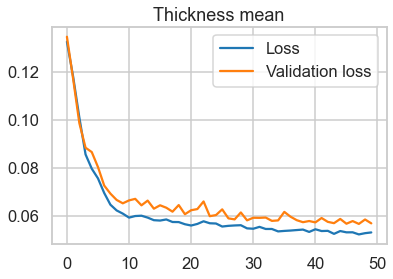

8/8 [==============================] - 0s 5ms/step - loss: 0.0568
loss: 0.05681874230504036
Thickness minimum
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 3s 13ms/step - loss: 0.1560 - val_loss: 0.1434
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1223 - val_loss: 0.1267
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1106 - val_loss: 0.1162
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1028 - val_loss: 0.1108
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0958 - val_loss: 0.1037
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0899 - val_loss: 0.1005
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0861 - val_loss: 0.0969
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.0829 - val_loss: 0.0936
Epoch 9/50
50/50 [==============================] - 0s 4ms/step

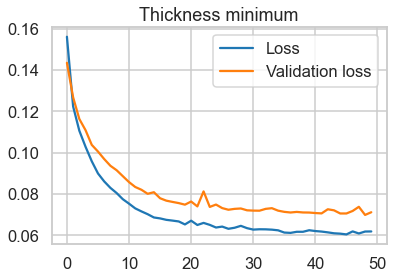

8/8 [==============================] - 0s 4ms/step - loss: 0.0712
loss: 0.07116340845823288
Thickness std
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 11ms/step - loss: 0.4263 - val_loss: 0.2220
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1975 - val_loss: 0.1769
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1644 - val_loss: 0.1545
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1464 - val_loss: 0.1411
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1320 - val_loss: 0.1344
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1215 - val_loss: 0.1234
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1138 - val_loss: 0.1184
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1087 - val_loss: 0.1137
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - l

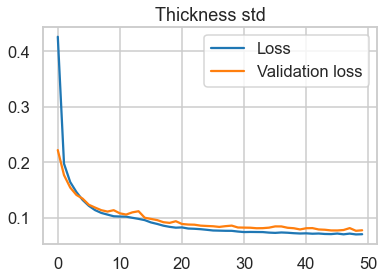

8/8 [==============================] - 0s 2ms/step - loss: 0.0774
loss: 0.0774337500333786
Depression depth
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 2s 21ms/step - loss: 0.2780 - val_loss: 0.2130
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1911 - val_loss: 0.1802
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1644 - val_loss: 0.1619
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1454 - val_loss: 0.1477
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1340 - val_loss: 0.1385
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1253 - val_loss: 0.1326
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.1180 - val_loss: 0.1264
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1142 - val_loss: 0.1236
Epoch 9/50
50/50 [==============================] - 0s 3ms/step -

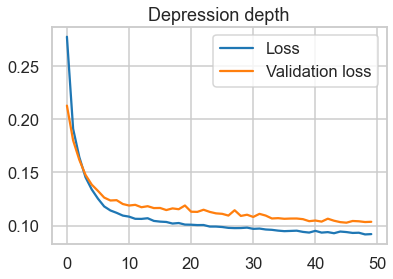

8/8 [==============================] - 0s 2ms/step - loss: 0.1035
loss: 0.10350953787565231
Depression width
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 3s 23ms/step - loss: 0.4885 - val_loss: 0.2560
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.2295 - val_loss: 0.2208
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2062 - val_loss: 0.2161
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1988 - val_loss: 0.2068
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1937 - val_loss: 0.2038
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1889 - val_loss: 0.2001
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1855 - val_loss: 0.1981
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 0.1830 - val_loss: 0.1974
Epoch 9/50
50/50 [==============================] - 0s 3ms/step 

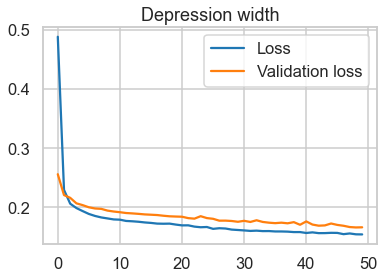

8/8 [==============================] - 0s 2ms/step - loss: 0.1663
loss: 0.16627056896686554
Pitting depth
Layer added; size: 4
Layer added; size: 2
Epoch 1/50
50/50 [==============================] - 1s 8ms/step - loss: 0.3432 - val_loss: 0.2985
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2838 - val_loss: 0.2784
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2673 - val_loss: 0.2669
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2539 - val_loss: 0.2574
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2501 - val_loss: 0.2543
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2476 - val_loss: 0.2529
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2461 - val_loss: 0.2536
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2453 - val_loss: 0.2558
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - lo

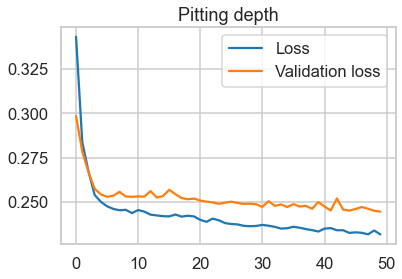

8/8 [==============================] - 0s 2ms/step - loss: 0.2446
loss: 0.24463139474391937


In [132]:
df_loss, df_test, df_predict, autoencoder_regression_models_fk, min_max_scalers = do_regression(encoded_all_fk, label_sample, attributes)

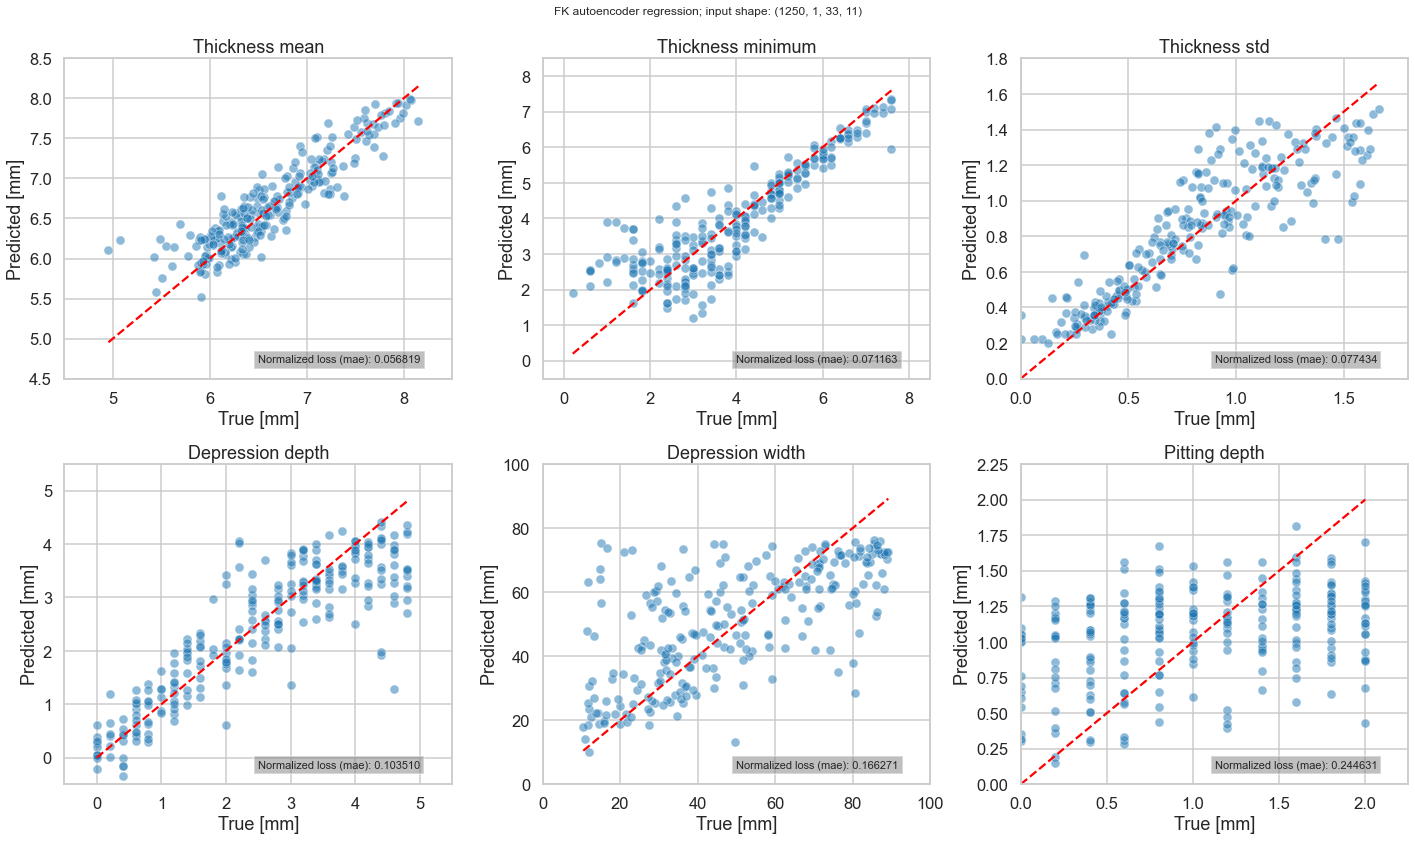

In [134]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='FK autoencoder regression; input shape: '+ str(X_sample_n_fk.shape))

In [135]:
df_test.columns

Index(['Thickness mean', 'Thickness minimum', 'Thickness std',
       'Depression depth', 'Depression width', 'Pitting depth'],
      dtype='object')

In [136]:
df_scales['Thickness mean'][0]

4.5

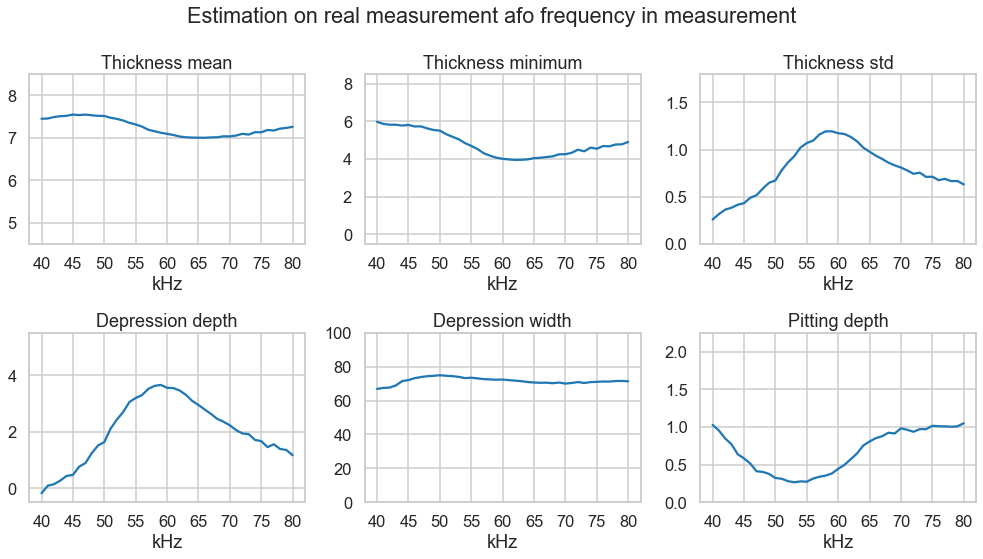

In [137]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
plt.figure(figsize=(14, 8))
for i, attribute in enumerate(attributes):
  real_prediction_norm = autoencoder_regression_models_fk[attribute](encoded_measurements_fk)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.subplot(2,3, i+1)
  plt.plot(real_prediction[attribute])
  plt.ylim([df_scales[attribute][0], df_scales[attribute][1]])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
plt.suptitle('Estimation on real measurement afo frequency in measurement')
plt.tight_layout()
plt.show()

In [138]:
cases_ideal

[121, 230, 231, 679, 896, 1006, 1133]

In [139]:
def decode_sample(autoencoder, sample):
  sample_flat = sample.reshape(np.prod(sample.shape))
  sample_flat = np.expand_dims(sample_flat, axis=0)
  decoded_sample = autoencoder.predict(sample_flat)
  decoded_sample_shaped = decoded_sample.reshape(sample.shape)
  return decoded_sample_shaped



1/1 [==============================] - 0s 22ms/step


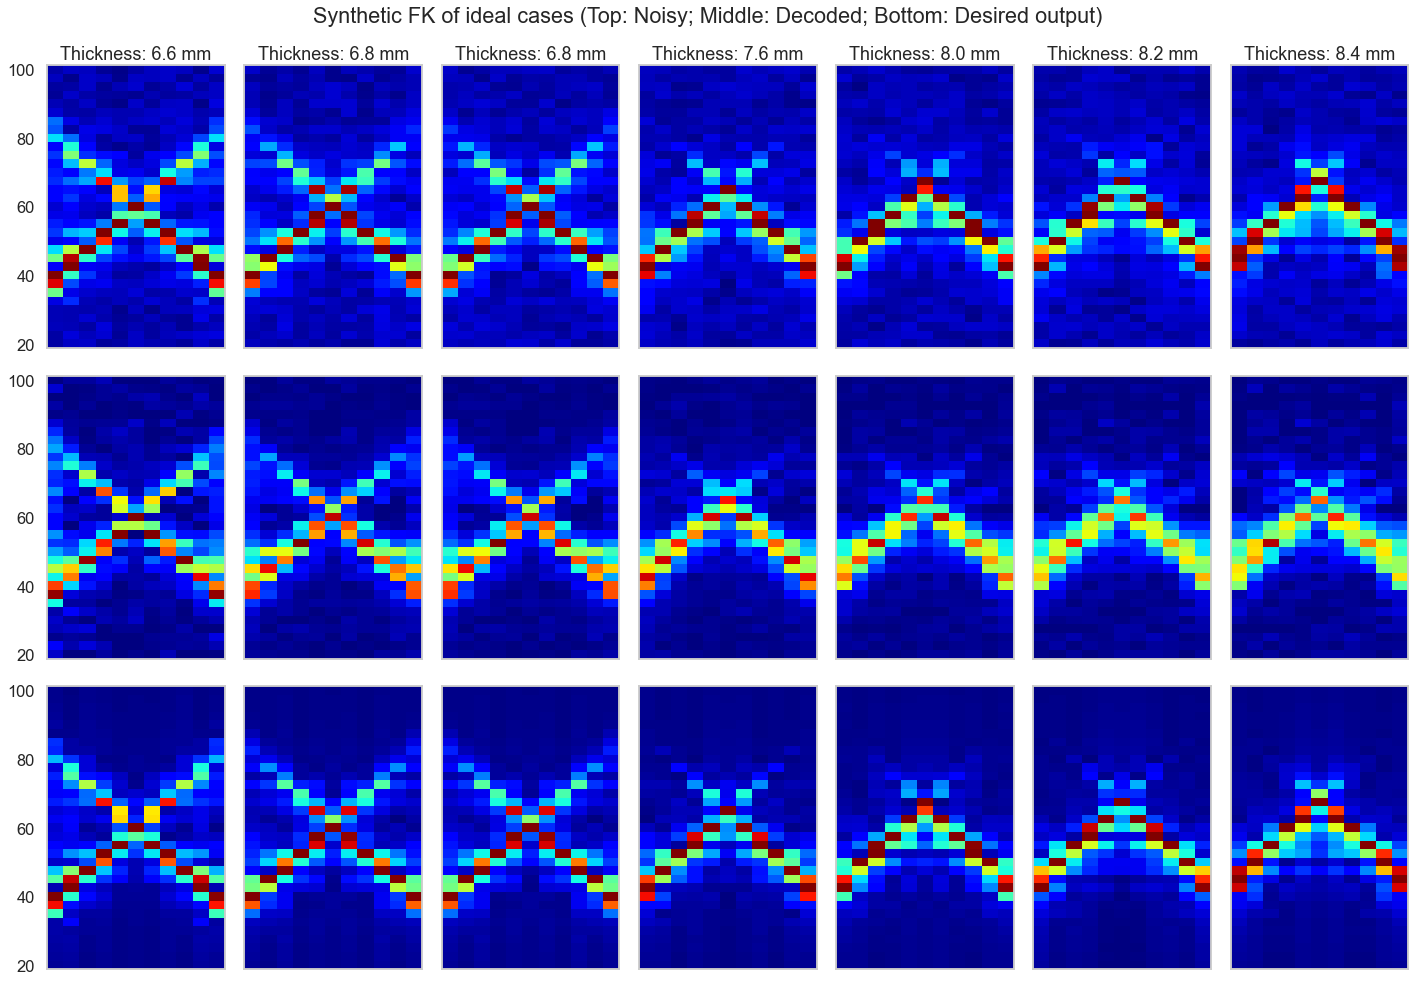

In [140]:
# Warning: These are not test-sets, but training sets.
plt.figure(figsize=(20,14))
for i, case in enumerate(cases_ideal):
  plt.subplot(3, len(cases_ideal), i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case, 0,:, :], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.title('Thickness: ' + str(labels.iloc[case]['Thickness mean']) + ' mm')
  plt.subplot(3, len(cases_ideal), len(cases_ideal)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[case,0,:,:]), cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.subplot(3, len(cases_ideal), 2*len(cases_ideal)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
plt.suptitle('Synthetic FK of ideal cases (Top: Noisy; Middle: Decoded; Bottom: Desired output)')
plt.tight_layout()
plt.show()

In [141]:
labels.iloc[case]['Thickness mean']

8.4

In [142]:
X_sample_n_fk.shape

(1250, 1, 33, 11)

In [143]:
real_prediction['Thickness mean'][20].item()

7.09282587187158

In [144]:
freqno = 20
limit = 0.5
labels[(labels['Thickness mean'] >= real_prediction['Thickness mean'][freqno].item() - limit  ) & (labels['Thickness mean'] <= real_prediction['Thickness mean'][freqno].item() + limit) &
       (labels['Thickness minimum'] >= real_prediction['Thickness minimum'][freqno].item() - limit) & (labels['Thickness minimum'] <= real_prediction['Thickness minimum'][freqno].item() +limit) &
       (labels['Depression depth'] >= real_prediction['Depression depth'][freqno].item() - limit) & (labels['Depression depth'] <= real_prediction['Depression depth'][freqno].item() + limit) &
       (labels['Pitting depth'] >= real_prediction['Pitting depth'][freqno].item() - limit) & (labels['Pitting depth'] <= real_prediction['Pitting depth'][freqno].item() + limit)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var
517,model_c3456_t036_d017_p001_s1899123873,7.2,1899123873,3.4,0.2,415.596573,40.382974,7.2,3.6,6.604687,7.0,0.983364,0.967006
636,model_c3456_t037_d016_p002_s1934290201,7.4,1934290201,3.2,0.4,401.160018,50.537935,7.4,3.8,6.612442,7.0,1.007397,1.014849
644,model_c3456_t037_d018_p000_s1901625839,7.4,1901625839,3.6,0.0,434.948356,52.269577,7.4,3.8,6.720313,7.4,1.131956,1.281324
645,model_c3456_t037_d018_p000_s1906040213,7.4,1906040213,3.6,0.0,422.065770,47.141172,7.4,3.8,6.786921,7.4,1.093855,1.196518
651,model_c3456_t037_d019_p000_s1918255890,7.4,1918255890,3.8,0.0,439.728891,46.464711,7.4,3.6,6.762095,7.4,1.148680,1.319466
738,model_c3456_t038_d016_p002_s1864630000,7.6,1864630000,3.2,0.4,403.438851,58.323952,7.6,4.0,6.732870,7.2,1.050200,1.102919
740,model_c3456_t038_d016_p003_s1912485529,7.6,1912485529,3.2,0.6,400.598616,54.046020,7.6,3.8,6.705613,7.2,1.032829,1.066735
742,model_c3456_t038_d017_p000_s1875672822,7.6,1875672822,3.4,0.0,416.681240,58.578631,7.6,4.2,6.880671,7.6,1.107291,1.226092
743,model_c3456_t038_d017_p000_s1926552484,7.6,1926552484,3.4,0.0,416.135298,54.956369,7.6,4.2,6.925174,7.6,1.086293,1.180032
744,model_c3456_t038_d017_p001_s1928287350,7.6,1928287350,3.4,0.2,417.489334,60.834689,7.6,4.0,6.752836,7.4,1.124632,1.264797


1/1 [==============================] - 0s 28ms/step


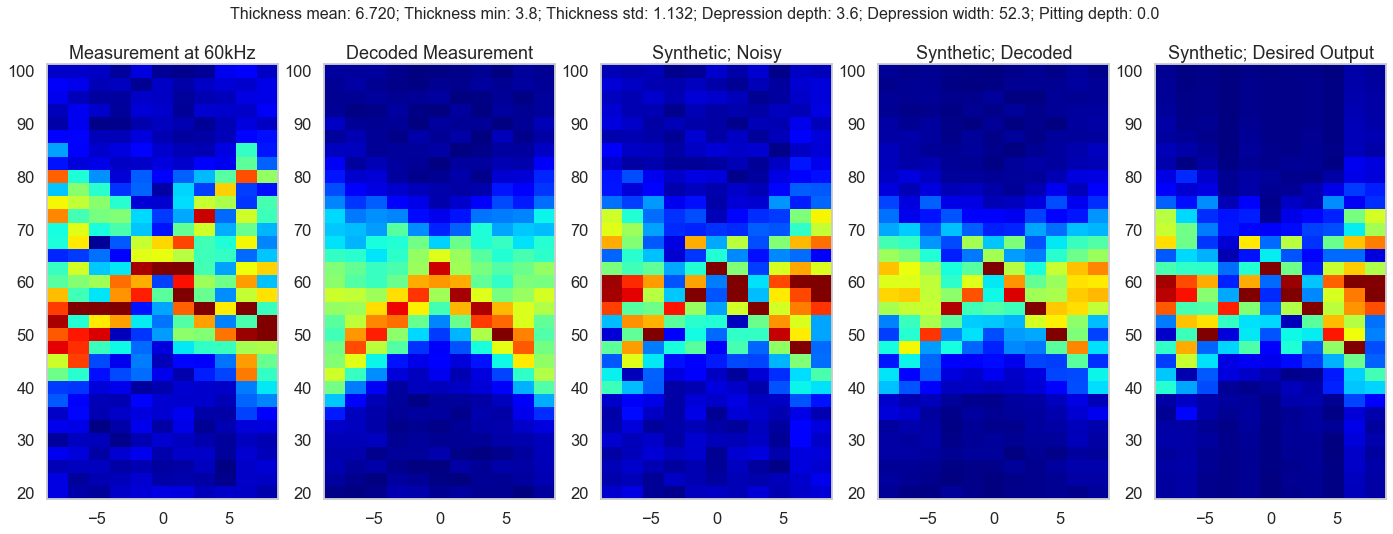

In [145]:
synthsample = 1095
synthsample = 644

titlestring = f"Thickness mean: {labels.iloc[synthsample]['Thickness mean']:.3f}; " \
              f"Thickness min: {labels.iloc[synthsample]['Thickness minimum']:.1f}; " \
              f"Thickness std: {labels.iloc[synthsample]['Thickness std']:.3f}; " \
              f"Depression depth: {labels.iloc[synthsample]['Depression depth']:.1f}; " \
              f"Depression width: {labels.iloc[synthsample]['Depression width']:.1f}; " \
              f"Pitting depth: {labels.iloc[synthsample]['Pitting depth']:.1f}"

plt.figure(figsize=(24,8))
plt.subplot(1,5,1)
plt.pcolormesh(x_array, f_array/1e3, measurements_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Measurement at ' + str(20+40) + 'kHz')
plt.subplot(1,5,2)
plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Decoded Measurement')
plt.subplot(1,5,3)
plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[synthsample, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Noisy')
plt.subplot(1,5,4)
plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[synthsample,0,:,:]), cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Decoded')
plt.subplot(1,5,5)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[synthsample, 0,:,:], cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Desired Output')
plt.suptitle(titlestring, fontsize=16)
plt.show()

In [146]:
# Check how FK looks for increasing thickness std
tolerance = 0.01
cases_increasing_std = labels[(labels['Thickness mean'] > 6.8-tolerance) & (labels['Thickness mean'] < 6.8 + tolerance)].sort_values(by='Thickness std').index.tolist()
#cases_increasing_std = labels[(labels['Thickness mean'] > 6.8-tolerance) & (labels['Thickness mean'] < 6.8 + tolerance)].sort_values(by='Pitting depth').index.tolist()
#cases_increasing_std = labels[(labels['Thickness mean'] > 6.8-tolerance) & (labels['Thickness mean'] < 6.8 + tolerance)].sort_values(by='Depression depth').index.tolist()

1/1 [==============================] - 0s 31ms/step


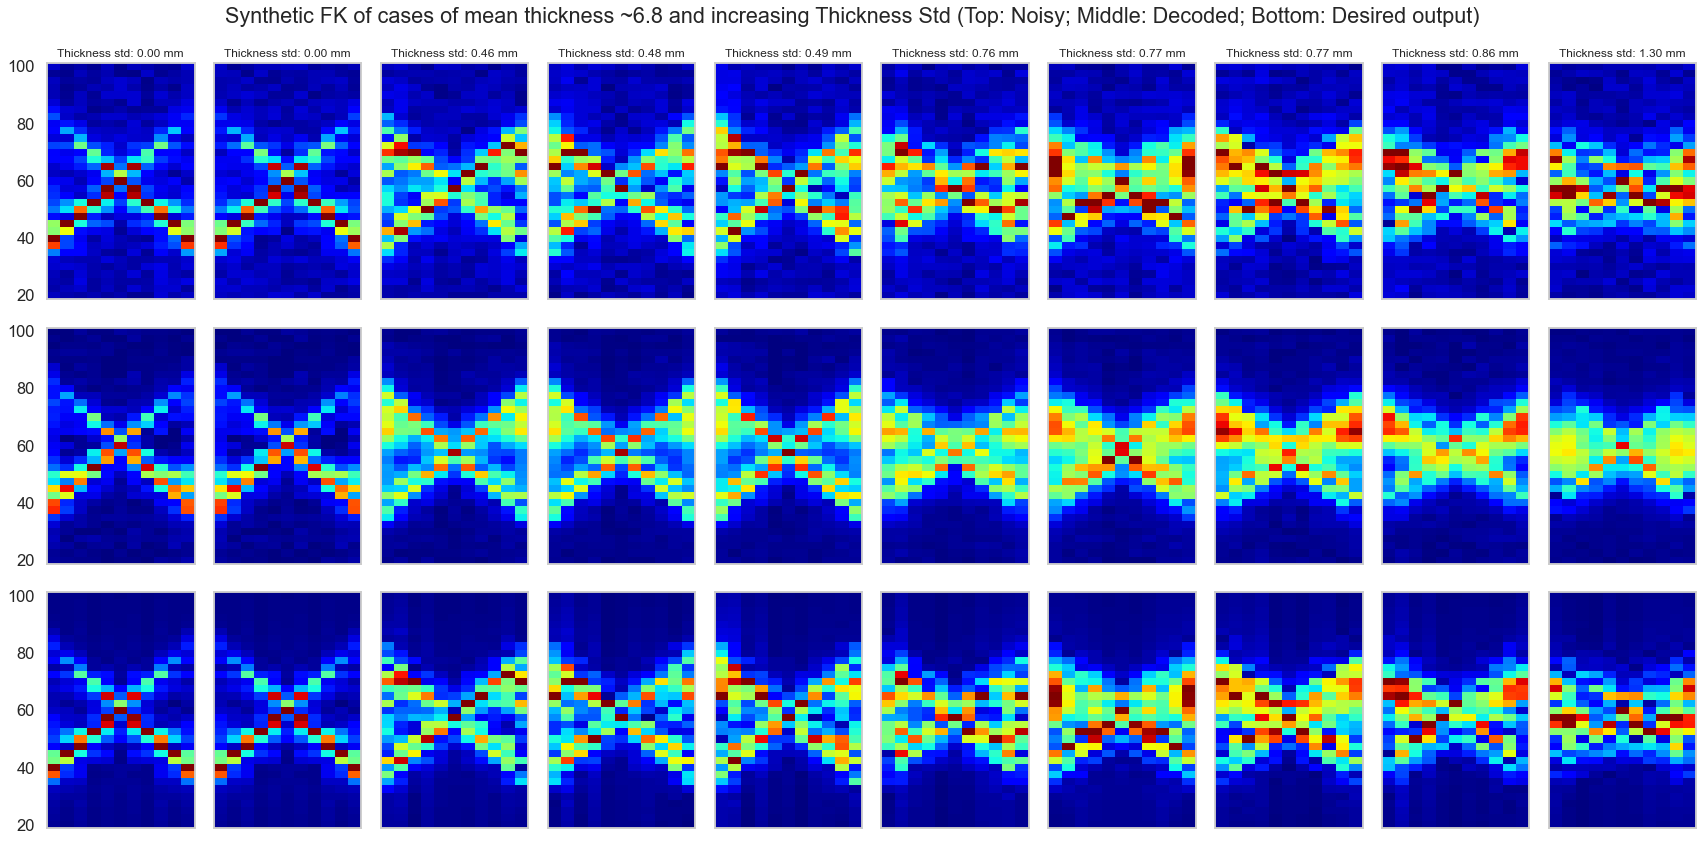

In [147]:
plt.figure(figsize=(24, 12))
for i, case in enumerate(cases_increasing_std):

  plt.subplot(3, len(cases_increasing_std), i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case, 0,:, :], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.title(f"Thickness std: {(labels.iloc[case]['Thickness std']):.2f} mm", fontsize=12)
  plt.subplot(3, len(cases_increasing_std), len(cases_increasing_std)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[case,0,:,:]), cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.subplot(3, len(cases_increasing_std), 2*len(cases_increasing_std)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
plt.suptitle('Synthetic FK of cases of mean thickness ~6.8 and increasing Thickness Std (Top: Noisy; Middle: Decoded; Bottom: Desired output)')
plt.tight_layout()

plt.show()

In [148]:
encoder_fk.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 363)]             0         
                                                                 
 dense_112 (Dense)           (None, 64)                23296     
                                                                 
 dense_113 (Dense)           (None, 32)                2080      
                                                                 
 dense_114 (Dense)           (None, 16)                528       
                                                                 
Total params: 25,904
Trainable params: 25,904
Non-trainable params: 0
_________________________________________________________________
